# INF581 Lab5: Reinforcement Learning - TD Learning, QLearning and SARSA

<img src="https://raw.githubusercontent.com/jeremiedecock/polytechnique-inf581-2024-students/main/logo.jpg" style="float: left; width: 15%" />

[INF581-2024](https://moodle.polytechnique.fr/course/view.php?id=17108) Lab session #5

2019-2024 Jérémie Decock

[![Open in Google Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jeremiedecock/polytechnique-inf581-2024-students/blob/main/lab5_rl2_tdlearning_qlearning_sarsa.ipynb)

[![My Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/jeremiedecock/polytechnique-inf581-2024-students/main?filepath=lab5_rl2_tdlearning_qlearning_sarsa.ipynb)

[![NbViewer](https://raw.githubusercontent.com/jupyter/design/main/logos/Badges/nbviewer_badge.svg)](https://nbviewer.jupyter.org/github/jeremiedecock/polytechnique-inf581-2024-students/blob/main/lab5_rl2_tdlearning_qlearning_sarsa.ipynb)

[![Local](https://img.shields.io/badge/Local-Save%20As...-blue)](https://github.com/jeremiedecock/polytechnique-inf581-2024-students/raw/main/lab5_rl2_tdlearning_qlearning_sarsa.ipynb)

## Introduction

The purpose of this lab is to introduce some classic concepts used
in reinforcement learning: *Temporal Difference Learning* (*TD Learning*), *QLearning* and *SARSA*.

**Notice**: Here we assume that the reward only depends on the state: $r(\boldsymbol{s}) \equiv \mathcal{R}(\boldsymbol{s}, \boldsymbol{a}, \boldsymbol{s}')$.

## Name your work

Replace the values in the following dictionary `info`. Your Email must match your class email address. Your Alias will be shown on the public leaderboard (to identify yourself).

In [2]:
info = {
        'Email' : 'yannis.kedadry@polytechnique.edu',
        'Alias' : 'yKedadry', # (change this in case you want to identify yourself on the leaderboard)
}

## Python requirements

This notebook requires the following Python libraries: *Gymnasium*, NumPy, Pandas, Seaborn.

### If you use Google Colab

Execute the next cell to install required libraries.

In [3]:
colab_requirements = [
    "gymnasium",
    "numpy",
    "pandas",
    "seaborn"
]
import sys, subprocess
def run_subprocess_command(cmd):
    # run the command
    process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE)
    # print the output
    for line in process.stdout:
        print(line.decode().strip())

if "google.colab" in sys.modules:
    for i in colab_requirements:
        run_subprocess_command("pip install " + i)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 6.2 MB/s eta 0:00:00


### If you use MyBinder

Required libraries are already installed, you have nothing to do.

### If you have downloaded the notebook on your computer and execute it in your own Python environment

Uncomment and execute the following cell to install required packages in your local environment (remove only the `#` not the `!`).

In [4]:
#!pip install gymnasium numpy pandas seaborn

## Import required libraries

In [5]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

import math
import gymnasium as gym
import numpy as np
import copy
import pandas as pd
import seaborn as sns

from typing import List, Optional, Tuple, Union, Callable, Dict, Sequence

In [6]:
sns.set_context("talk")

In [7]:
#matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

## Setup the FrozenLake toy problem with Gymnasium

For the purpose of focusing on the algorithms, we will use standard environments provided
by the Gymnasium framework. Especially, as in Lab 4, we will try to solve the FrozenLake-v1
problem (https://gymnasium.farama.org/environments/toy_text/frozen_lake/).
As a reminder, this environment is described [here](https://gymnasium.farama.org/environments/toy_text/frozen_lake/).

<img src="https://gymnasium.farama.org/_images/frozen_lake.gif">

The action indices are outlined below:

| Action Index | Action     |
|--------------|------------|
| 0            | Move Left  |
| 1            | Move Down  |
| 2            | Move Right |
| 3            | Move Up    |

The following dictionary may be used to understand actions:

In [1]:
## EXTRACT
action_labels = {
    0: "Move Left",
    1: "Move Down",
    2: "Move Right",
    3: "Move Up"
}

**Notice**: this environment is *fully observable*, thus here the terms (environment) *state* and (agent) *observation* are equivalent.
This is not always the case for example in poker, the agent doesn't know the opponent's cards.

### Display functions

The next cells contain two functions that can be used to display Q-tables in the FrozenLake environment.

In [9]:
# Display the Q-table as a set of heatmaps, one for each action
def qtable_display(
    q_array: np.ndarray,
    title: Optional[str] = None,
    figsize: Tuple[int, int] = (4, 4),
    annot: bool = True,
    fmt: str = "0.1f",
    linewidths: float = .5,
    square: bool = True,
    cbar: bool = False,
    cmap: str = "Reds"
) -> None:
    """
    Display a Q-table as a set of heatmaps, one for each action.

    For the frozen lake environment, there are 16 states and 4 actions thus this function will display 4 heatmaps, one for each action.
    Each heatmap will display the Q-values for each state when performing the action indexed by the heatmap.

    Parameters
    ----------
    q_array : np.ndarray
        The Q-table to display. Each row corresponds to a state, and each column corresponds to an action.
        In the frozen lake environment, there are 16 states and 4 actions thus the Q-table has a shape of (16, 4).
        For instance, q_array[0, 3] is the Q-value (estimation of the expected reward) for performing action 3 ("move up") in state 0 (the top left square).
    title : str, optional
        The title of the plot, by default None
    figsize : tuple, optional
        The size of the figure (in inches), by default (4, 4)
    annot : bool, optional
        If True, write the data value in each cell, by default True
    fmt : str, optional
        The string formatting code to use when adding annotations, by default "0.1f" that will display a single decimal
    linewidths : float, optional
        The width of the lines that will divide each cell, by default .5
    square : bool, optional
        Whether to set the Axes aspect to "equal" so each cell is square-shaped, by default True
    cbar : bool, optional
        Whether to draw a colorbar, by default False
    cmap : str, optional
        The mapping from data values to color space, by default "Reds"

    Returns
    -------
    None
    """
    # Get the number of actions from the shape of the Q-table
    num_actions = q_array.shape[1]

    # Adjust the figure size (in inches) based on the number of actions
    global_figsize = list(figsize)
    global_figsize[0] *= num_actions

    # Create a subplot for each action
    fig, ax_list = plt.subplots(ncols=num_actions, figsize=global_figsize)

    # For each action, display the Q-values for all states as a heatmap
    for action_index in range(num_actions):
        ax = ax_list[action_index]

        # Retrieve the Q-values for each state when performing the action indexed by "action_index".
        # This forms a 1D array, state_vec, where state_vec[i] = Q(i, action_index).
        state_vec = q_array[:,action_index]

        # Display the Q-values for each state when performing the action indexed by "action_index"
        # i.e. display Q(., action_index)
        states_display(
            state_vec,
            title=r"$Q(\cdot,a_{})$".format(action_index),
            #title=r"$Q(\cdot,a_{})$ {}".format(action_index, action_labels[action_index]),
            figsize=figsize,
            annot=annot,
            fmt=fmt,
            linewidths=linewidths,
            square=square,
            cbar=cbar,
            cmap=cmap,
            ax=ax
        )

    # Set the title for the entire figure
    plt.suptitle(title)
    # Display the figure
    plt.show()

In [10]:
def states_display(
    state_seq: Sequence[float],
    title: Optional[str] = None,
    figsize: Tuple[int, int] = (5, 5),
    annot: bool = True,
    fmt: str = "0.1f",
    linewidths: float = .5,
    square: bool = True,
    cbar: bool = False,
    cmap: str = "Reds",
    ax: Optional[matplotlib.axes.Axes] = None
) -> Optional[matplotlib.axes.Axes]:
    """
    Display the expected values of all states as a heatmap.

    Parameters
    ----------
    state_seq : Sequence[float]
        The sequence of expected values to display. This can be a list, a 1D array, etc.
        Each element is the estimation of the expected value of the corresponding state.
        For example, state_seq[0] is the estimation of the expected value of the first state.
        There are 16 elements in this sequence for the frozenlake environment, i.e., one per state of the environment.
    title : str, optional
        The title of the plot, by default None
    figsize : tuple, optional
        The size of the figure (in inches), by default (5, 5)
    annot : bool, optional
        If True, write the data value in each cell, by default True
    fmt : str, optional
        The string formatting code to use when adding annotations, by default "0.1f"
    linewidths : float, optional
        The width of the lines that will divide each cell, by default .5
    square : bool, optional
        Whether to set the Axes aspect to "equal" so each cell is square-shaped, by default True
    cbar : bool, optional
        Whether to draw a colorbar, by default False
    cmap : str, optional
        The mapping from data values to color space, by default "Reds"
    ax : matplotlib.axes.Axes, optional
        The axes object to draw the heatmap on, by default None

    Returns
    -------
    matplotlib.axes.Axes, optional
        The axes object with the heatmap if one was provided, otherwise None.
    """
    # Calculate the size of the state array
    size = int(math.sqrt(len(state_seq)))
    # Convert the state sequence to a numpy array (if it isn't already one)
    state_array = np.array(state_seq)
    # Reshape the state array into a square matrix
    # (we assume here that the frozen lake environment is used,
    # thus the state space can be visualized as a square grid)
    state_array = state_array.reshape(size, size)

    # If no axes object is provided, create a new figure and axes
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    # Create a heatmap of the state array on the axes
    ax = sns.heatmap(
        state_array,
        annot=annot,
        fmt=fmt,
        linewidths=linewidths,
        square=square,
        cbar=cbar,
        cmap=cmap,
        ax=ax
    )

    # If a title is provided, set the title of the plot
    if title is not None:
        ax.set_title(title)

    # If no axes object was provided, display the plot
    # Otherwise, return the axes object with the heatmap
    if ax is None:
        plt.show()
    else:
        return ax

## Exercise 1: Implement the TD Learning algorithm

In Lab4, we explored Dynamic Programming methods that can be used to solve Markov Decision Problems when the environment is perfectly known to the agent, i.e., in cases where the agent knows the transition and reward functions in advance. However, this is a strong assumption, as in most practical problems, these functions are not known beforehand. In this lab, we will learn how to create agents that can solve Markov Decision Problems without prior knowledge of the environment. These agents learn the dynamics of their environment by exploring it and use this knowledge to find an optimal policy.

We will start with the *TD Learning* (*Temporal Difference Learning*) algorithm, which can be used to **evaluate** any **given policy** (i.e., compute the *value function* or *V Table* of the environment following the given policy, which is the expected value of any state when the agent follows the provided policy).
However, the main ideas of this algorithm can also be used within optimal control methods, like e.g., [TD-Gammon](https://en.wikipedia.org/wiki/TD-Gammon).
Exercises 2 to 4 also reuse the main concepts of TD Learning to calculate an optimal policy.

The algorithm is outlined below.

---
TD Learning
---

<b>Input</b>:<br>
	$\quad\quad$ the policy $\pi$ to be evaluated<br>
<b>Algorithm parameter</b>:<br>
	$\quad\quad$ step size $\alpha \in (0,1]$<br><br>

Initialize arbitrarily $V(\boldsymbol{s}) ~~~ \forall \boldsymbol{s} \in \mathcal{S}$<br>
$V(\boldsymbol{s}_F) \leftarrow 0 ~~~ \forall \boldsymbol{s}_F \in \mathcal{S}^F$ (initialize finale states)<br><br>

<b>FOR EACH</b> episode<br>
	$\quad$ $S \leftarrow \text{env.reset}()$<br>
	$\quad$ <b>DO</b> <br>
		$\quad\quad$ $A \leftarrow \pi(S)$<br>
		$\quad\quad$ $S', R \leftarrow \text{env.step}(A)$<br>
		$\quad\quad$ $V(S) \leftarrow V(S) + \alpha \left[ \underbrace{\overbrace{R + \gamma ~ V(S')}^{\text{Target for } V(S)} ~ - ~ V(S)}_{\text{TD error}} \right]$<br>
		$\quad\quad$ $S \leftarrow S'$<br>
	$\quad$ <b>UNTIL</b> $S$ is final

**Notice**: in the following cell, `policy` is a list of actions (one per state c.f. two cells bellow).

In [65]:
## EXTRACT

DISPLAY_EVERY_N_EPISODES = 50

# Initialize the history of the value function and learning rate
value_function_history_ex1 = []
alpha_history_ex1 = []

def td_learning(
    policy: Sequence[float],
    environment: gym.Env,
    alpha: float = 0.1,
    alpha_factor: float = 0.995,
    gamma: float = 0.95,
    num_episodes: int = 1000,
    display: bool = False
) -> np.ndarray:
    """
    Perform Temporal Difference learning on a given policy and environment.

    Parameters
    ----------
    policy : Sequence[float]
        The policy to be learned, represented as a sequence mapping states (the index of the sequence) to actions (the value of the sequence for this index).
        For example, policy[0] is the action to take in state 0.
    environment : gym.Env
        The environment in which the agent operates.
    alpha : float, optional
        The learning rate, between 0 and 1. By default 0.1
    alpha_factor : float, optional
        The factor by which the learning rate alpha decreases each episode, by default 0.995
    gamma : float, optional
        The discount factor, between 0 and 1. By default 0.95
    num_episodes : int, optional
        The number of episodes to run, by default 1000
    display : bool, optional
        Whether to display the value function (every DISPLAY_EVERY_N_EPISODES episodes), by default False

    Returns
    -------
    np.ndarray
        The learned value function. This is a 1D ndarray with a shape of (16,) as there are 16 states in the frozenlake environment.
    """

    # Get the number of states in the environment
    num_states = environment.observation_space.n
    # Initialize the value function to zeros
    v_array = np.zeros(num_states)

    # Loop over the episodes
    for episode_index in range(num_episodes):
        # Display the value function every DISPLAY_EVERY_N_EPISODES episodes if display is True
        if display and episode_index % DISPLAY_EVERY_N_EPISODES == 0:
            states_display(
                v_array,
                title=f"Value function (ep. {episode_index})",
                cbar=True,
                cmap="Reds"
            )
        else:
            print('.', end="")

        # Save the current value function and learning rate
        value_function_history_ex1.append(v_array.copy())
        alpha_history_ex1.append(alpha)

        # Decrease the learning rate if alpha_factor is not None
        if alpha_factor is not None:
            alpha = alpha * alpha_factor

        # TODO...
        S = environment.reset()
        S = S[0]
        while True:
          A = policy[S]
          S_prime, R, end, _, _ = environment.step(A)
          v_array[S] += alpha * (R + gamma*v_array[S_prime]-v_array[S])
          S = S_prime
          if end:
            break

    # Return the learned value function
    return v_array

**Note**: In the following cell, the `display` argument can be set to `True` to see the evolution of the value function `v_array` over iterations.

In [66]:
# Define the policy to evaluate
policy = [0, 3, 3, 3,
          0, 0, 0, 0,
          3, 1, 0, 0,
          0, 2, 1, 0]

# Create the environment and set the maximum number of steps per episode
environment = gym.make('FrozenLake-v1')
environment._max_episode_steps = 1000

# Initialize the history of the value function and learning rate
value_function_history_ex1.clear()
alpha_history_ex1.clear()

# Apply Temporal Difference (TD) Learning to calculate the value function for the policy defined earlier, within the context of the FrozenLake environment.
v_array = td_learning(policy, environment, display=False)

environment.close()

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

<Axes: title={'center': 'Value function'}>

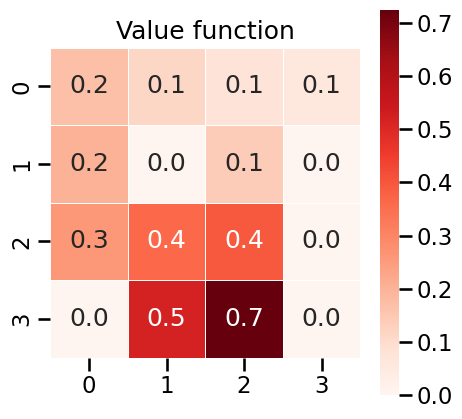

In [67]:
# Display the learned value function
states_display(v_array, title="Value function", cbar=True, cmap="Reds")

### Display the evolution of the value function over iterations

In [68]:
# Print the evolution of the value function during the learning process
df_v_hist_ex1 = pd.DataFrame(value_function_history_ex1)
df_v_hist_ex1

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.099500,0.0
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.009358,0.188652,0.0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000789,0.016144,0.0,0.0,0.023371,0.254024,0.0
4,0.000000,0.000000,0.000000,0.000000,0.000006,0.0,0.003125,0.0,0.000495,0.006124,0.033902,0.0,0.0,0.019548,0.327141,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.172289,0.114301,0.076156,0.059427,0.202009,0.0,0.140338,0.0,0.262830,0.363484,0.394199,0.0,0.0,0.519131,0.724021,0.0
996,0.172319,0.114301,0.076156,0.059427,0.202014,0.0,0.140338,0.0,0.262987,0.363447,0.394399,0.0,0.0,0.518778,0.724209,0.0
997,0.172298,0.114301,0.076156,0.059427,0.201875,0.0,0.140338,0.0,0.262854,0.363549,0.394332,0.0,0.0,0.518953,0.724214,0.0
998,0.172275,0.114301,0.076156,0.059427,0.201689,0.0,0.140338,0.0,0.262822,0.363567,0.394299,0.0,0.0,0.519050,0.724400,0.0


Evolution of `v_array` (the estimated expected value of each state) over iterations (one curve per state):

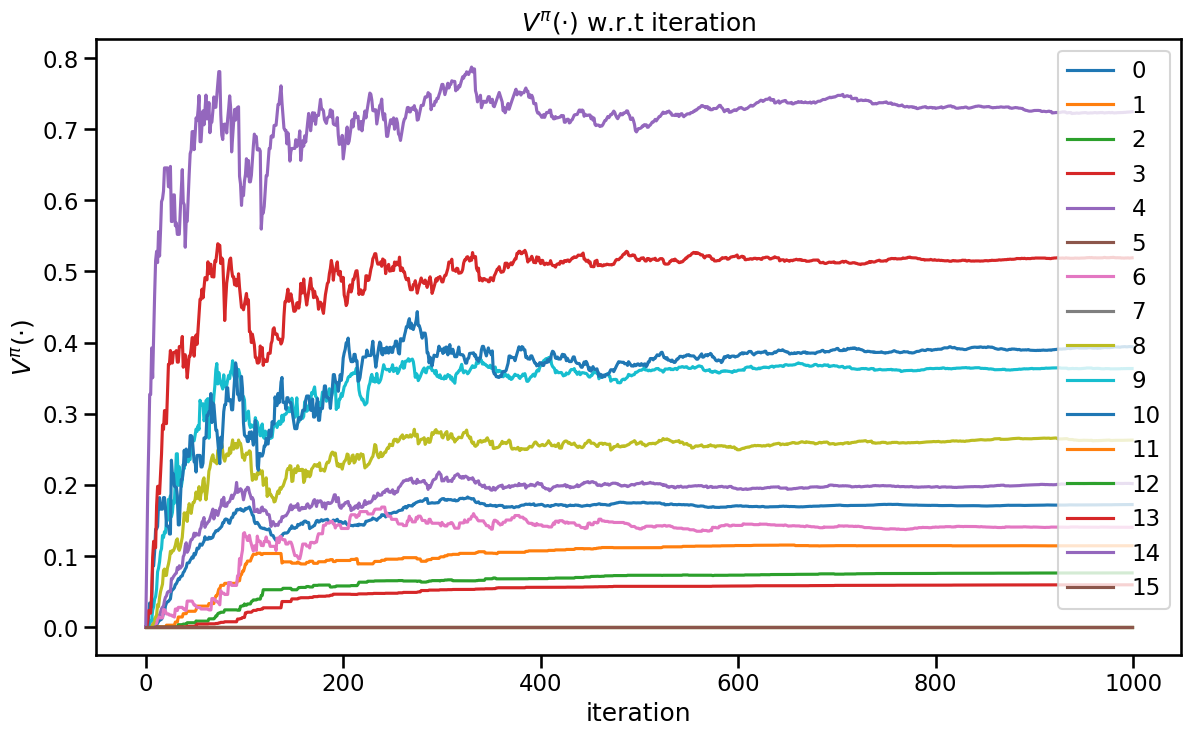

In [69]:
# Show the evolution of the estimated expected value for each state during the learning process
df_v_hist_ex1.plot(figsize=(14,8))
plt.title(r"$V^{\pi}(\cdot)$ w.r.t iteration")
plt.ylabel(r"$V^{\pi}(\cdot)$")
plt.xlabel("iteration")
plt.legend(loc='upper right');

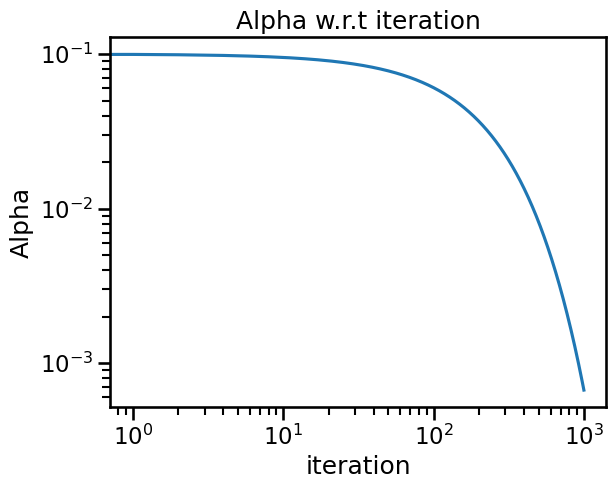

In [70]:
# Show the evolution of the alpha parameter during the learning process
plt.loglog(alpha_history_ex1)
plt.title("Alpha w.r.t iteration")
plt.ylabel("Alpha")
plt.xlabel("iteration");

## Exercise 2: The learning rate $\alpha$ in TD-Learning

In the previous exercise, set `alpha_factor` to 1 and check the algorithm with different values between 0 and 1.

What do you observe ?
What is the role of `alpha_factor` ?

cur alpha_factor:  0.0
.................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

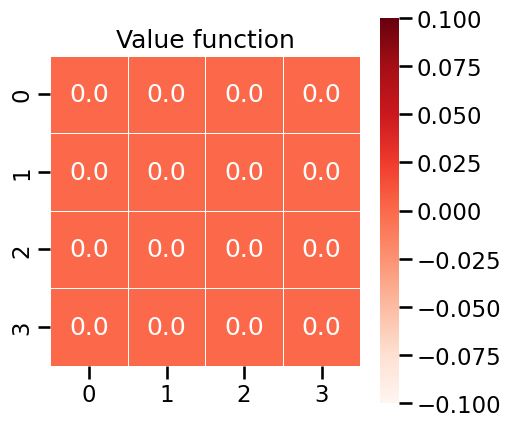

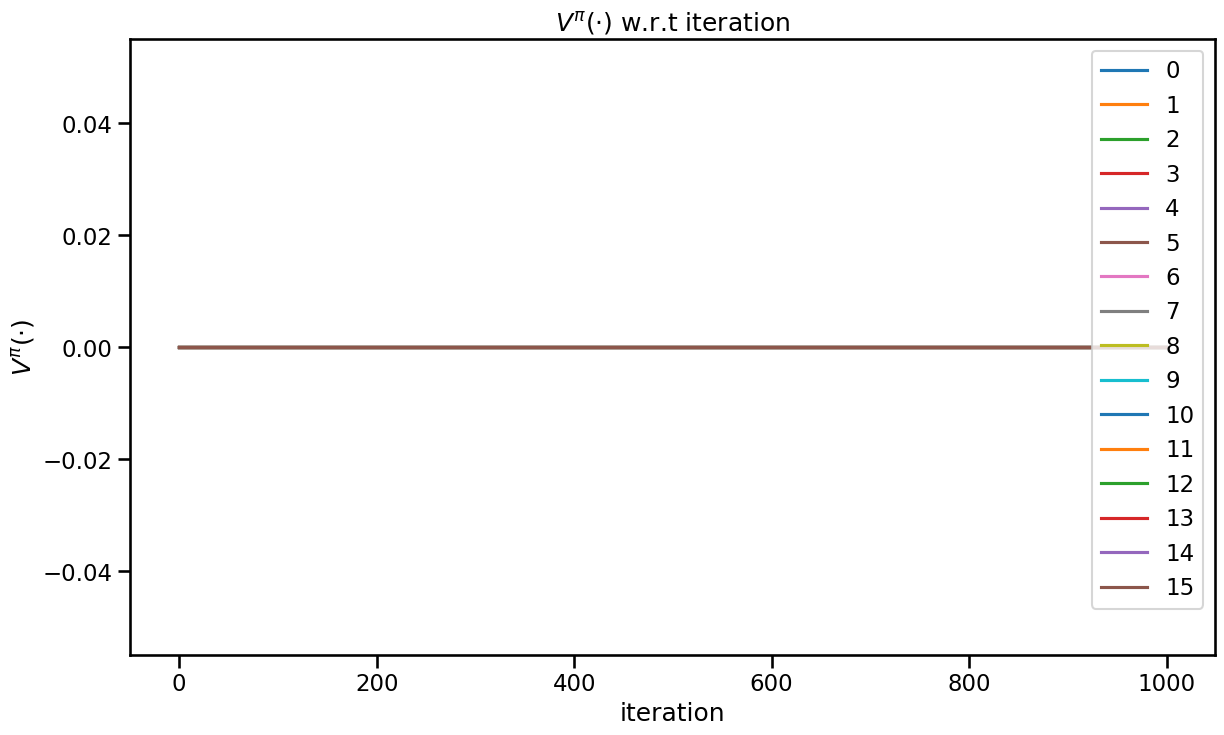

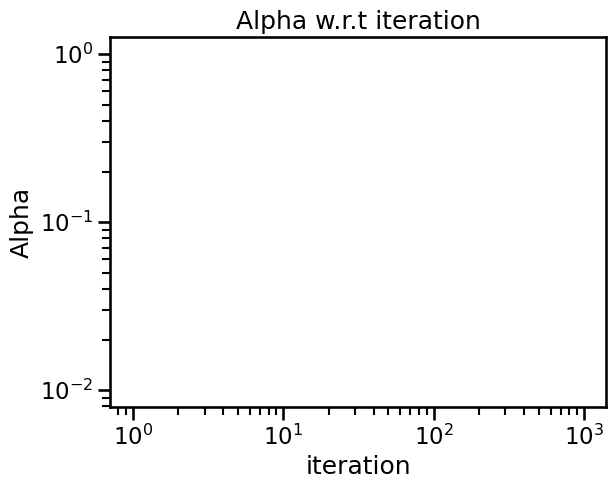

cur alpha_factor:  0.1
.................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

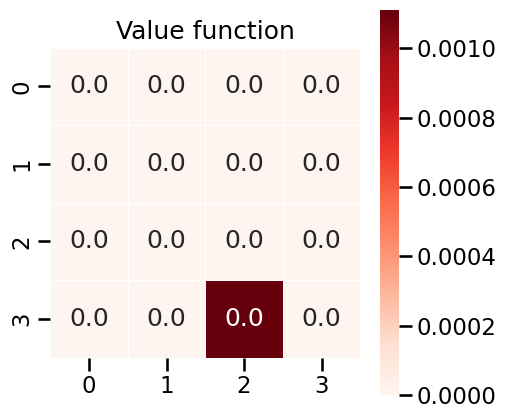

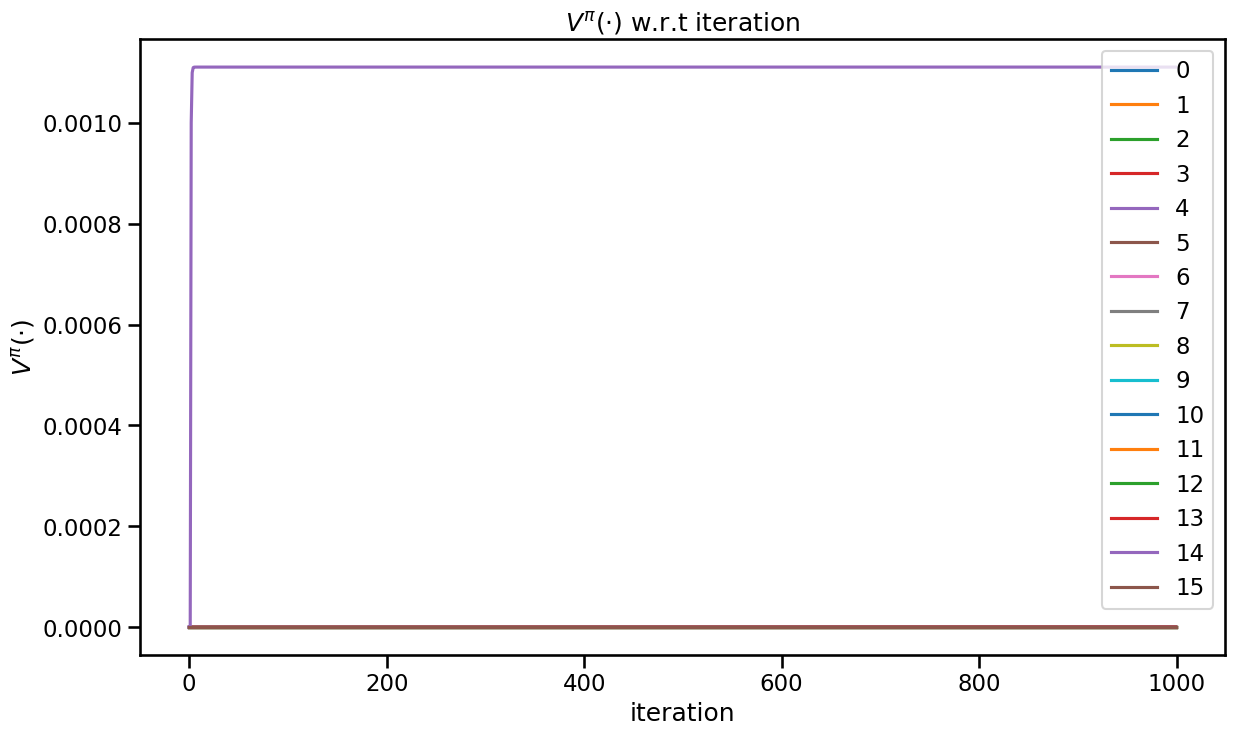

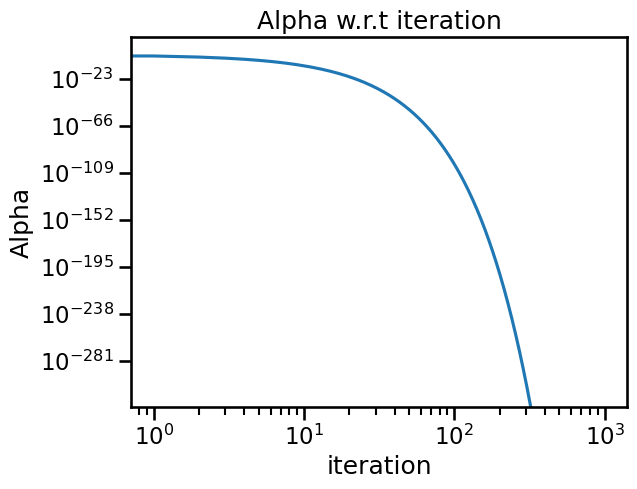

cur alpha_factor:  0.2
.................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

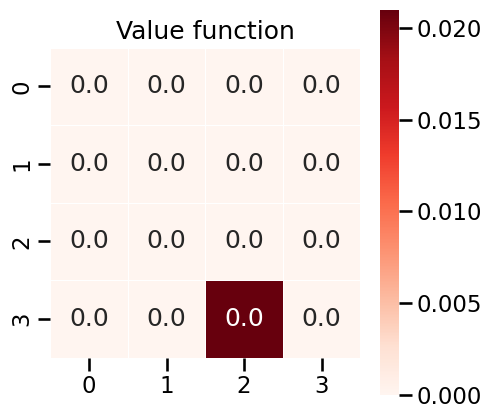

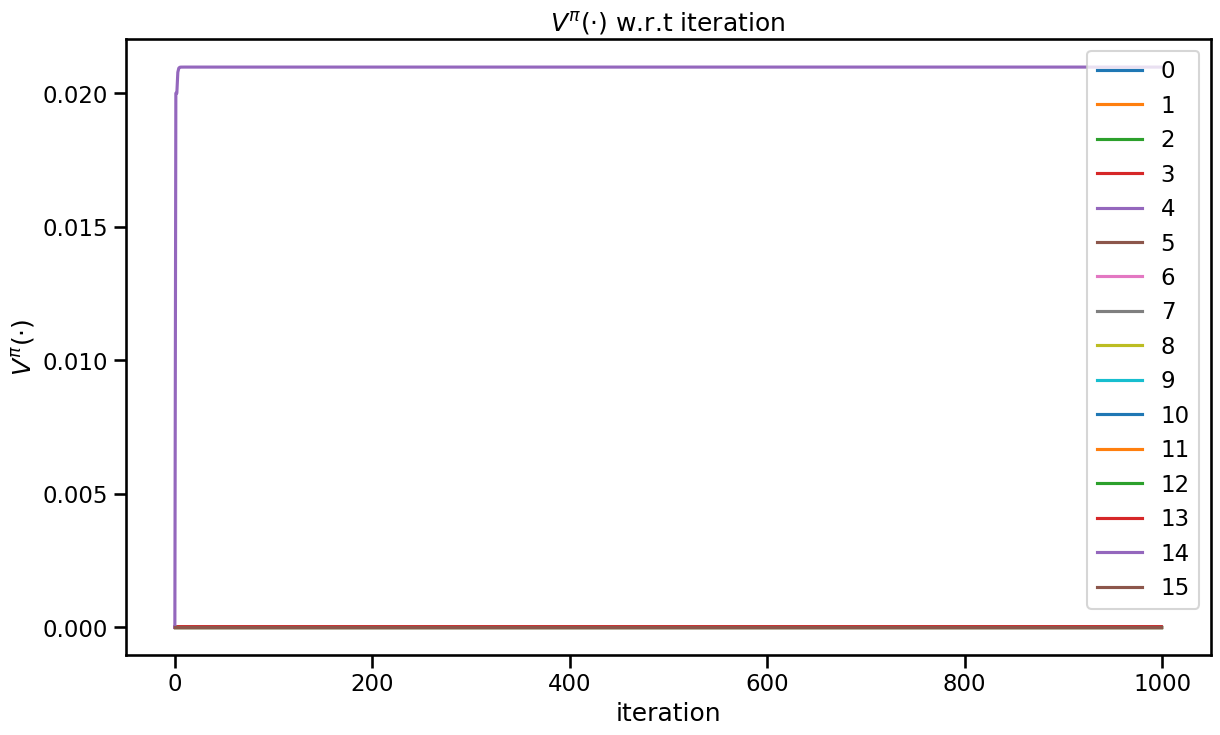

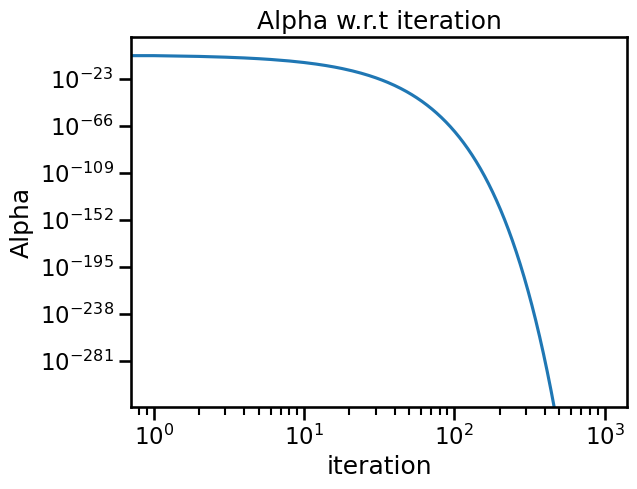

cur alpha_factor:  0.3
.................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

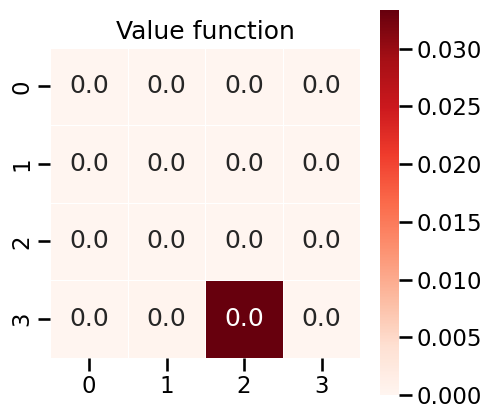

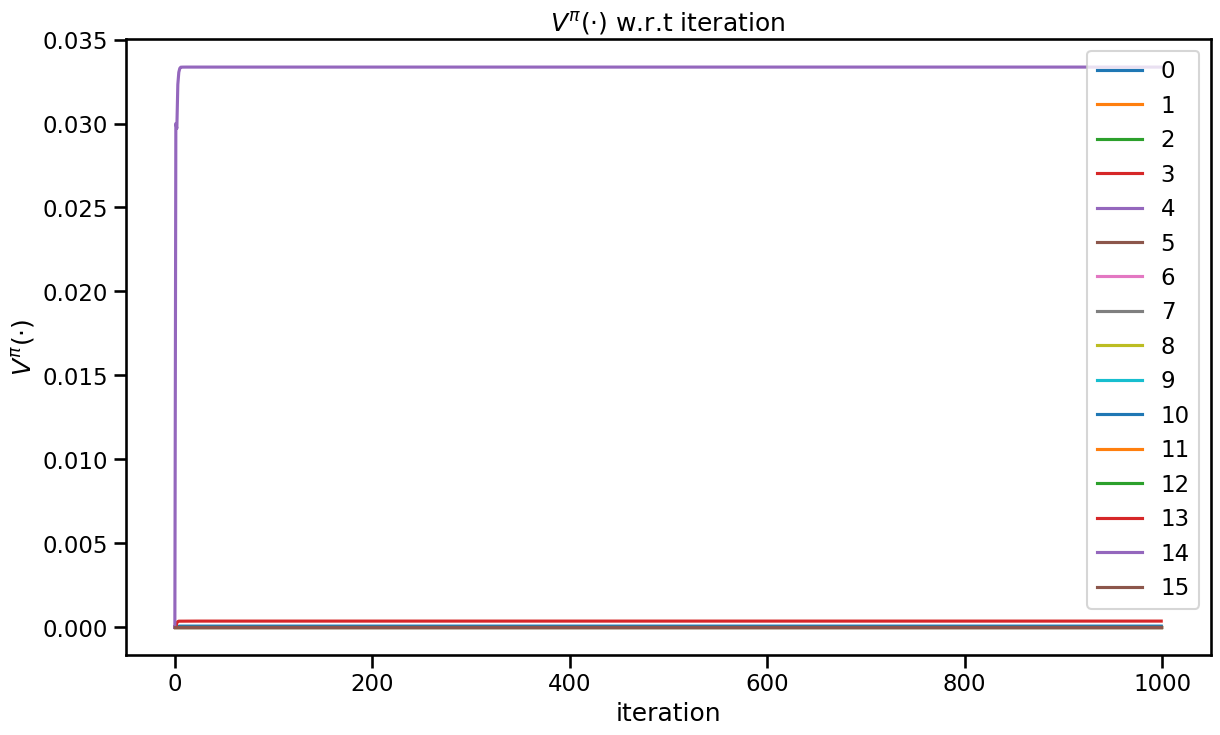

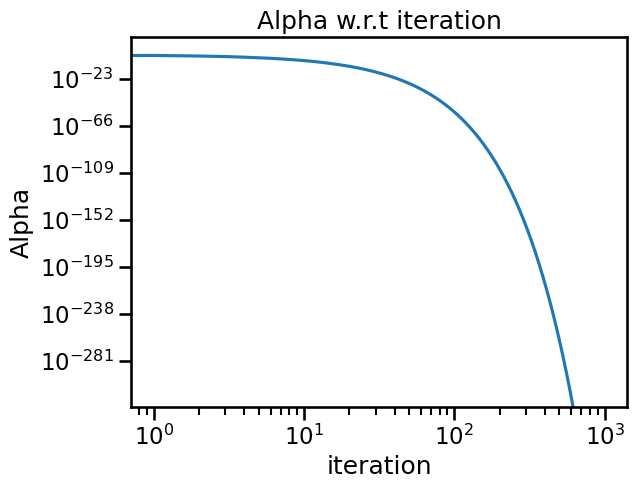

cur alpha_factor:  0.4
.................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

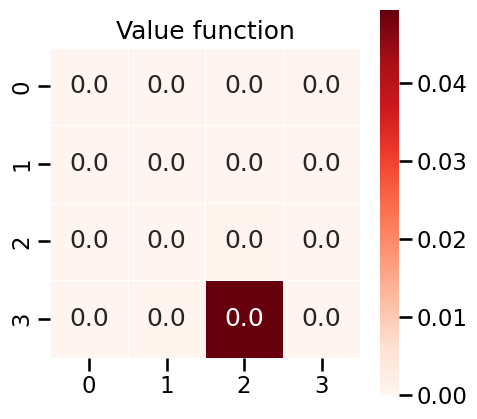

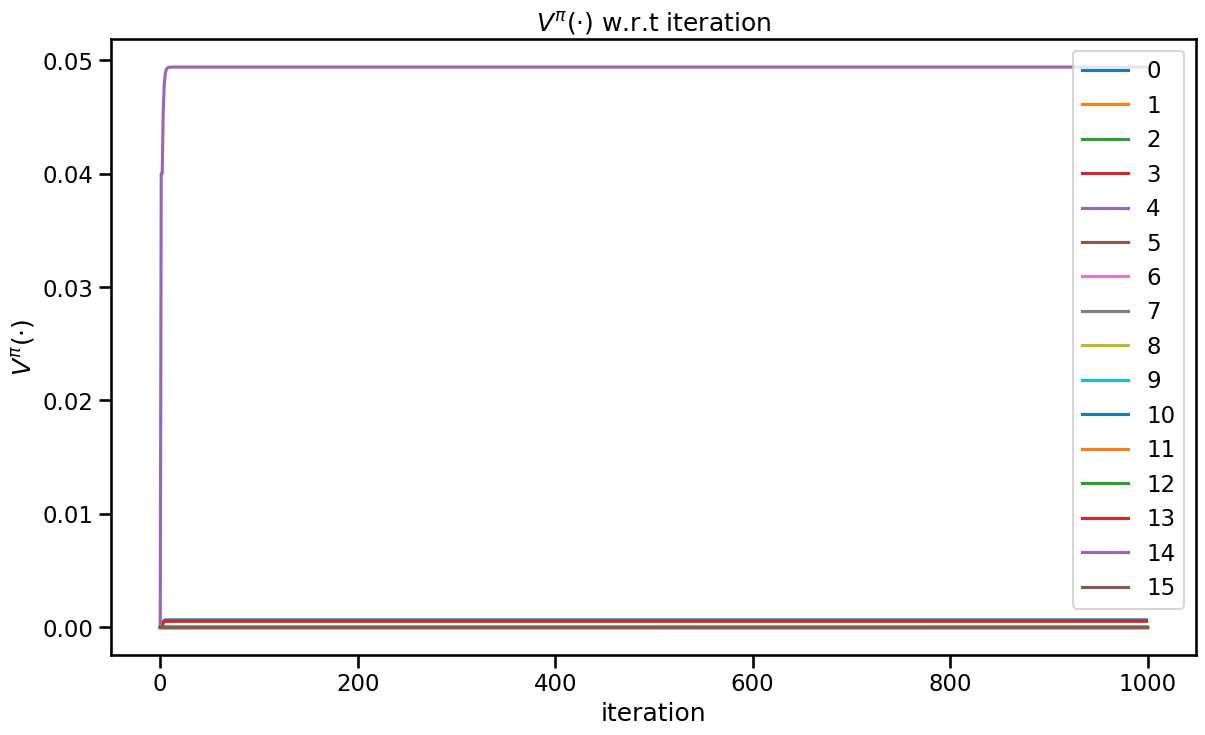

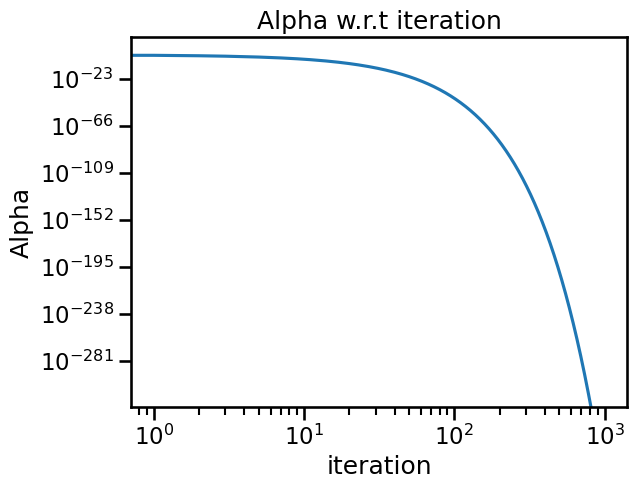

cur alpha_factor:  0.5
.................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

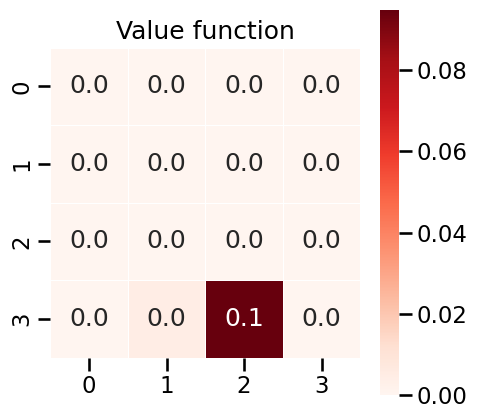

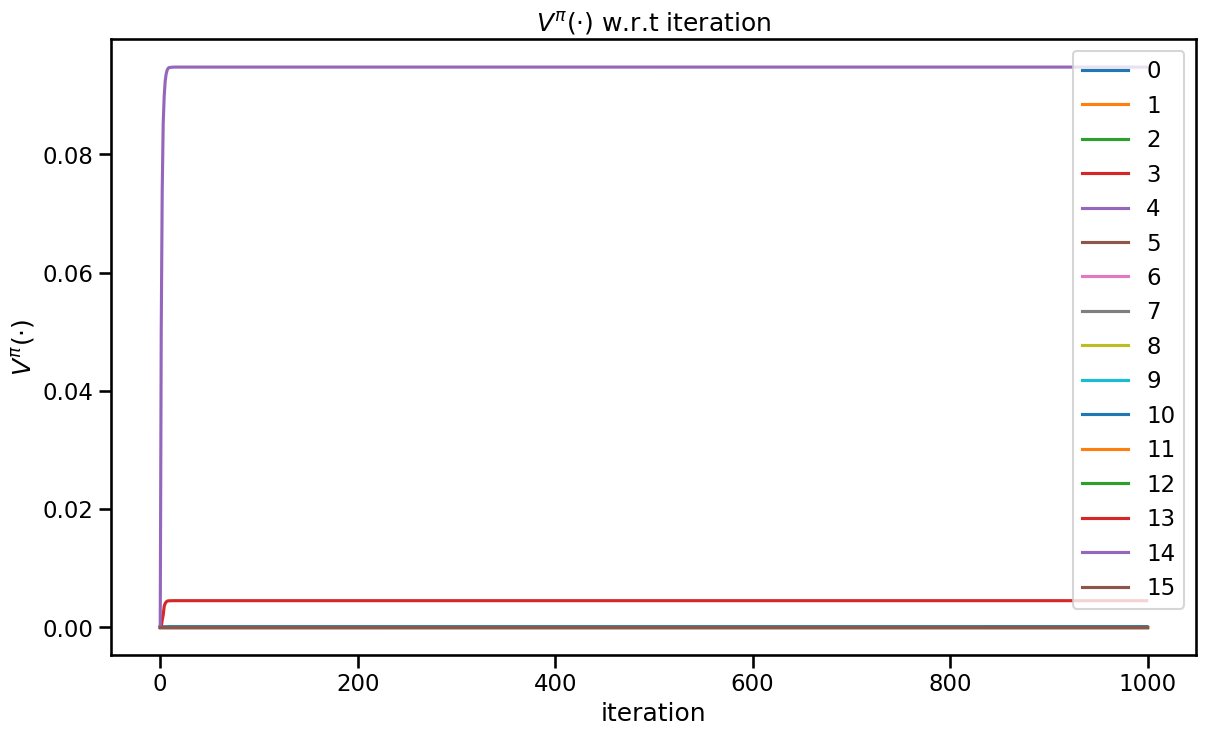

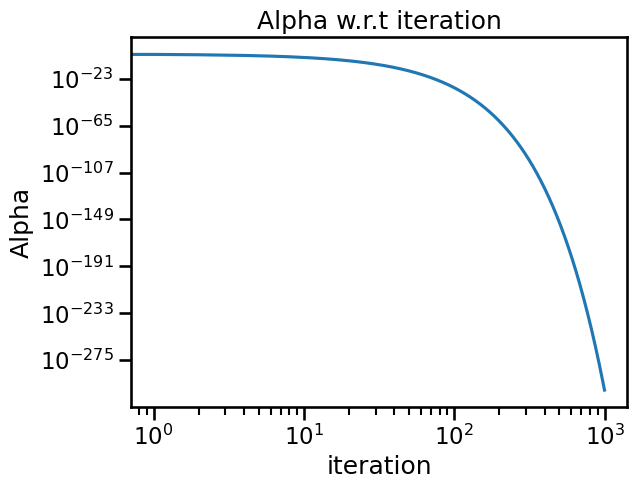

cur alpha_factor:  0.6
.................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

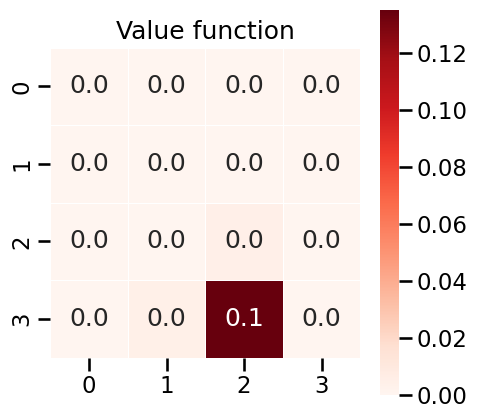

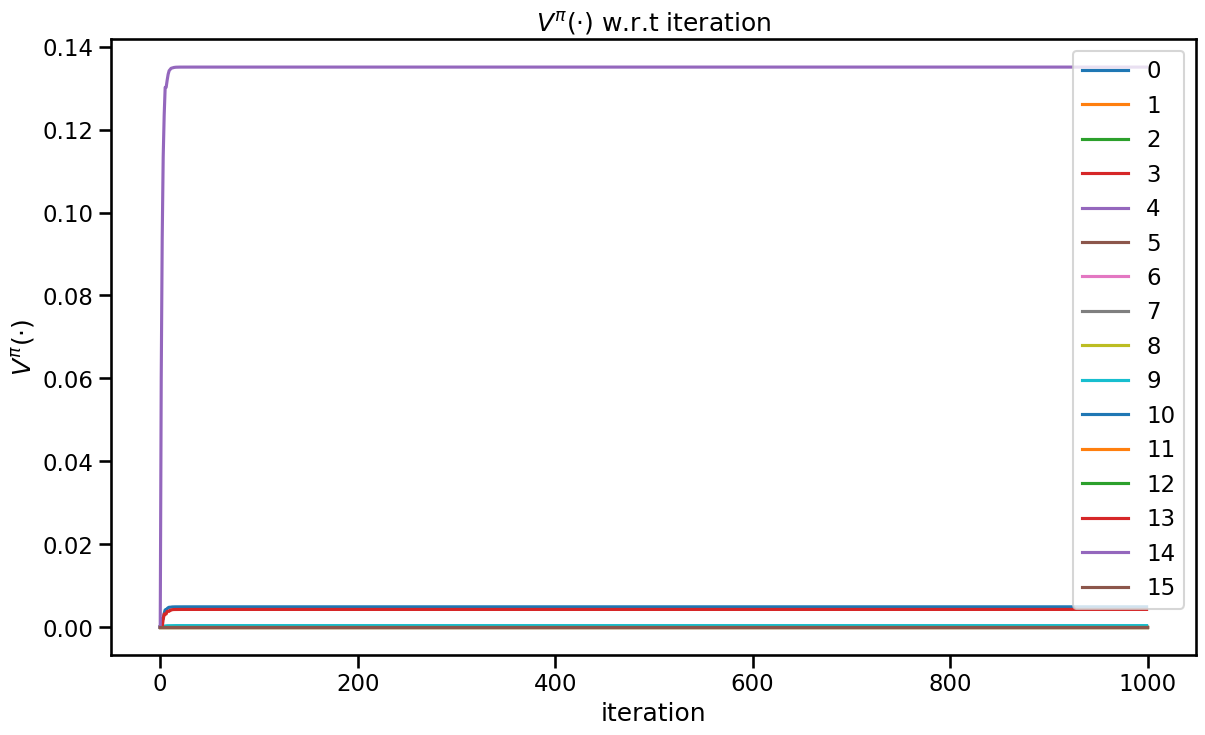

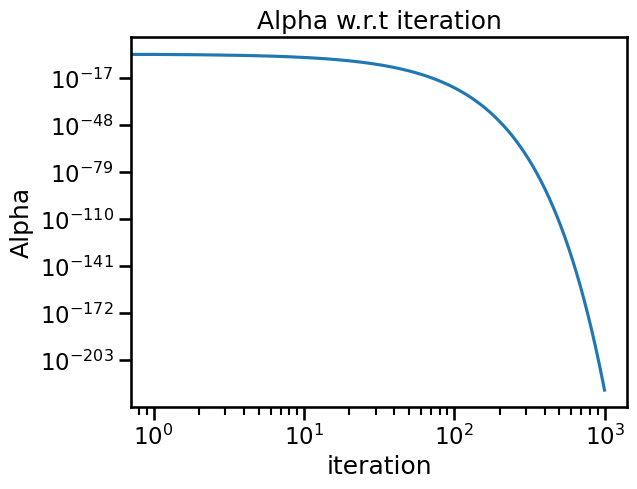

cur alpha_factor:  0.7
.................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

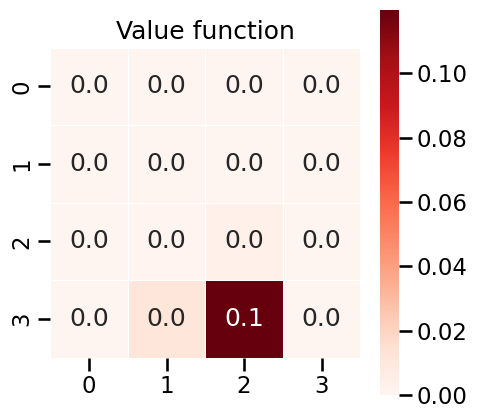

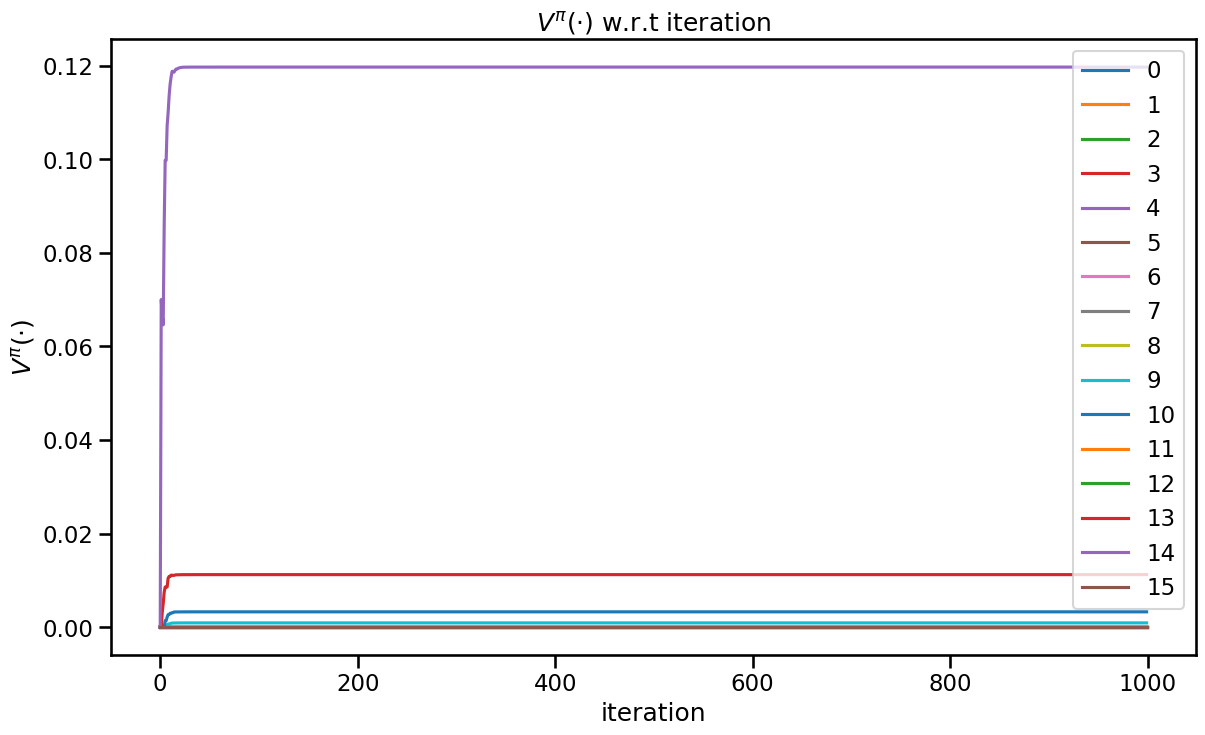

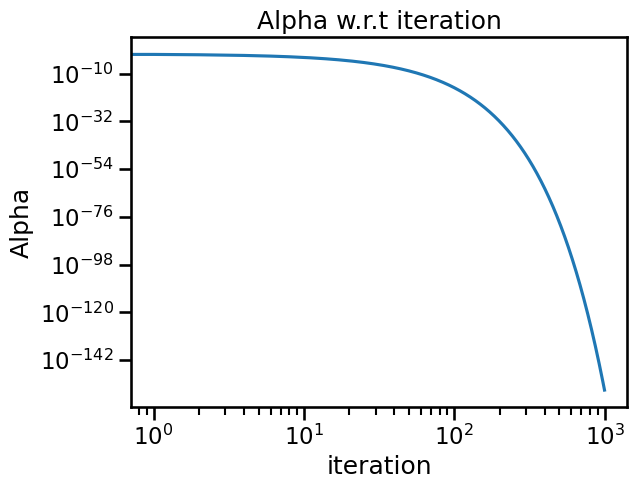

cur alpha_factor:  0.8
.................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

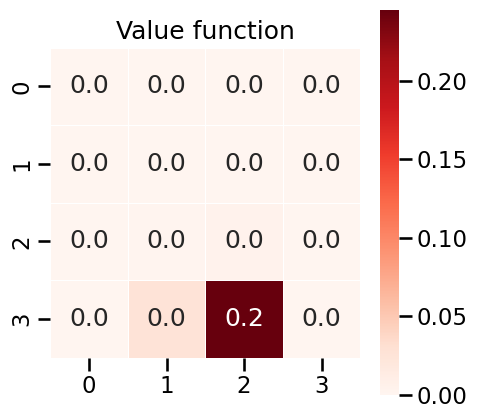

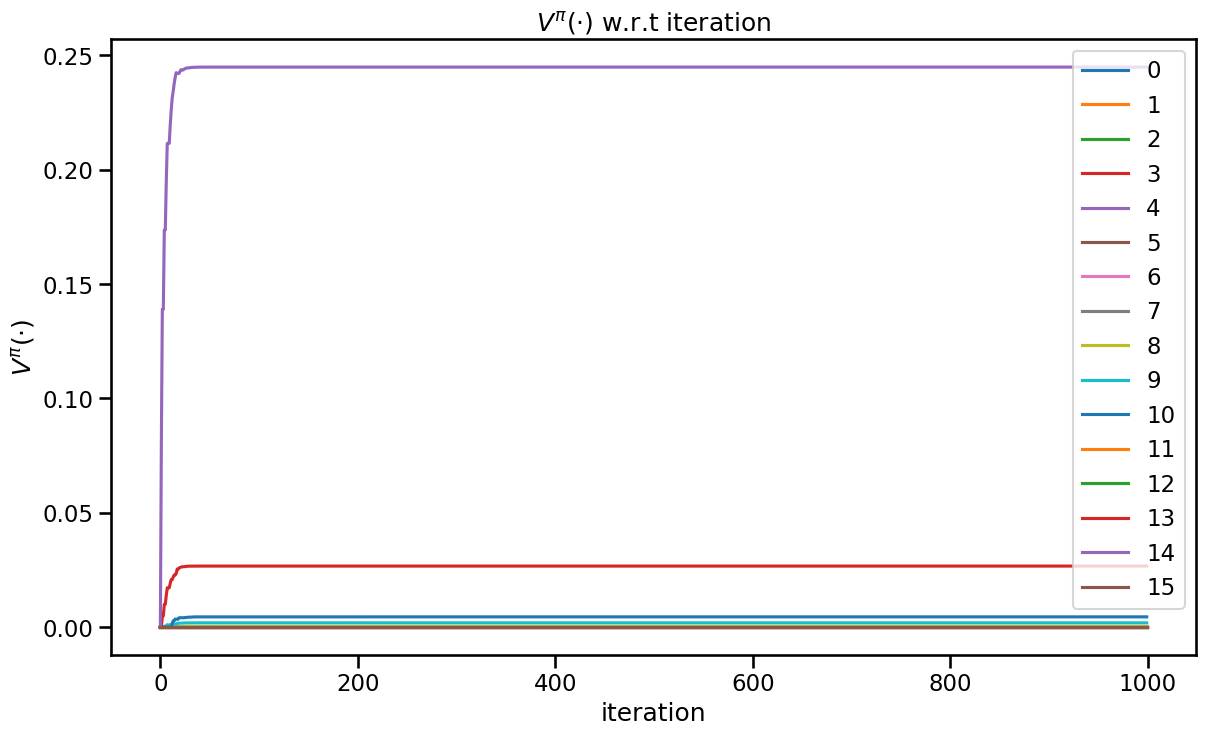

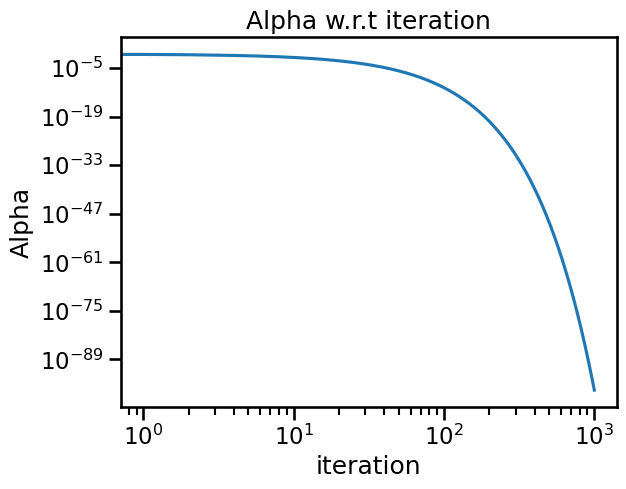

cur alpha_factor:  0.9
.................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

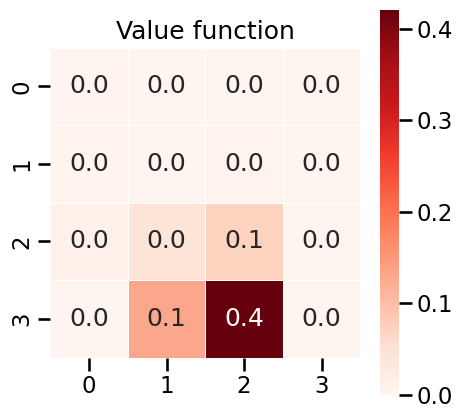

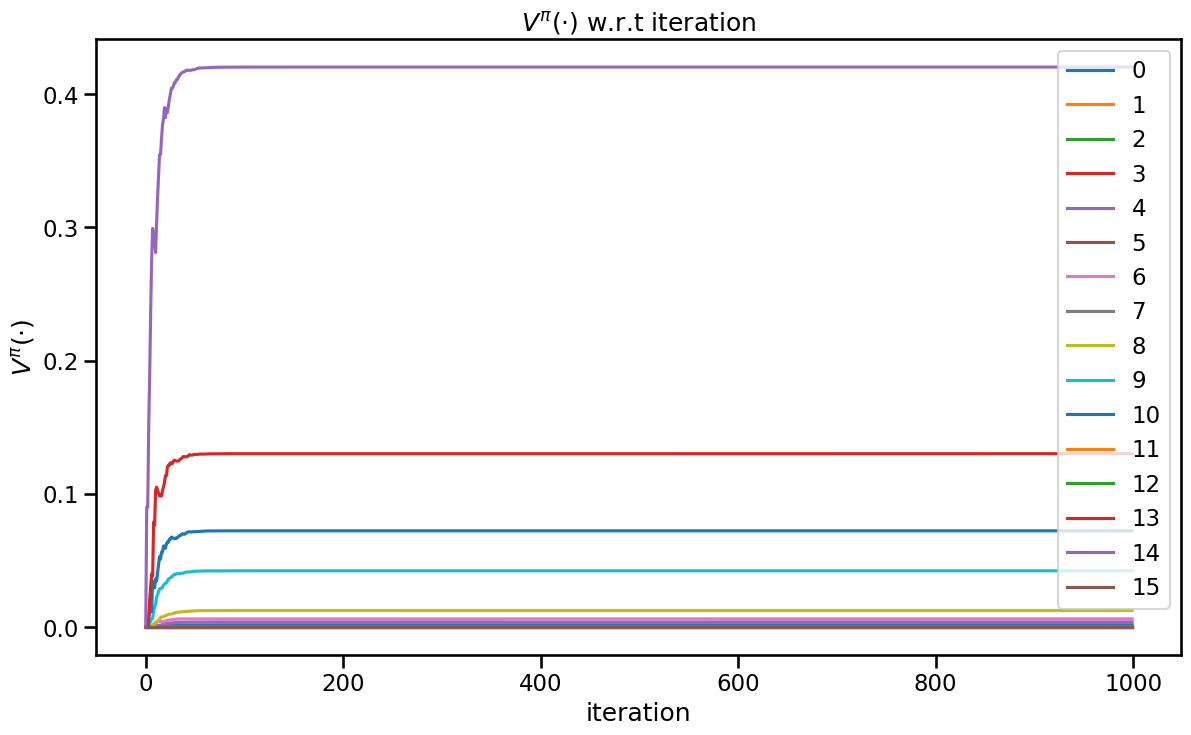

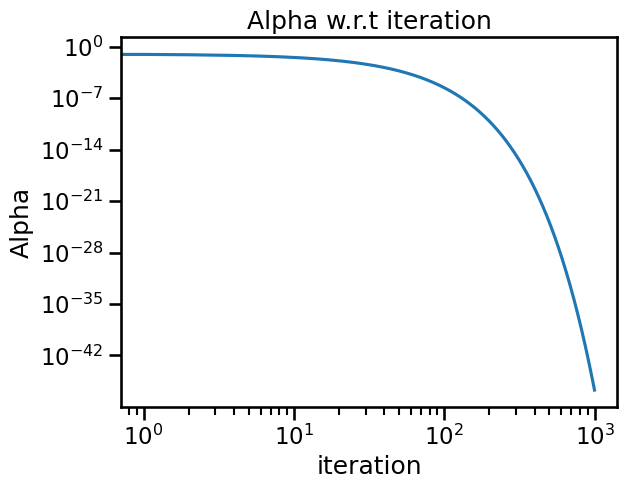

cur alpha_factor:  1.0
.................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

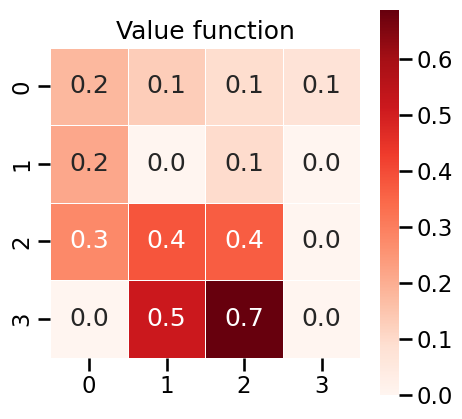

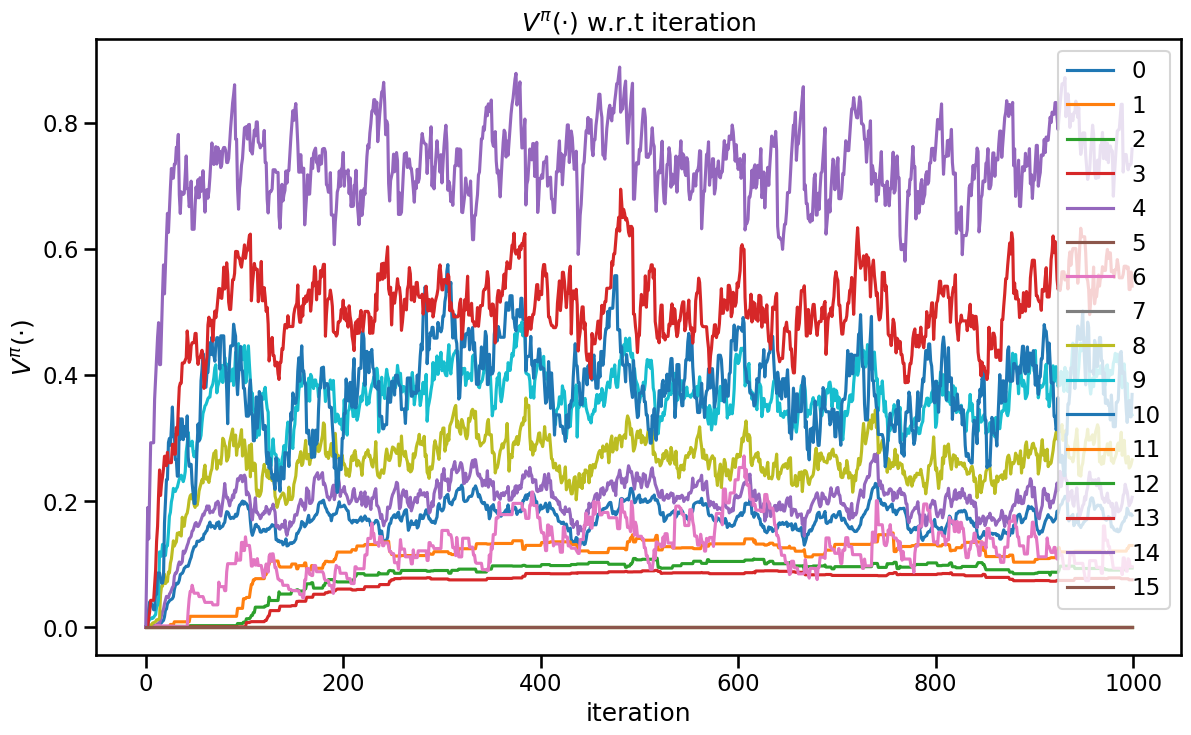

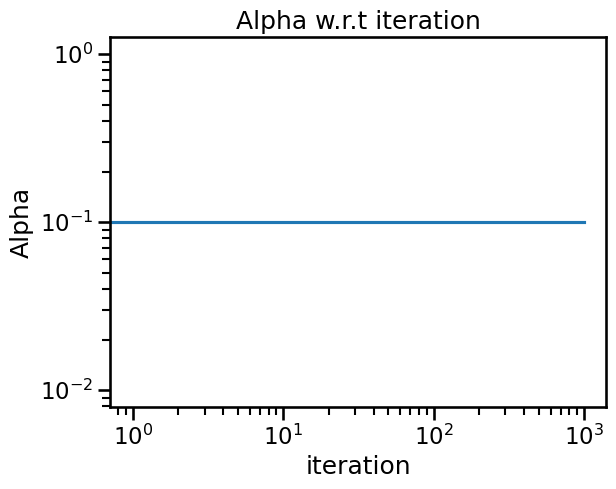

In [73]:
# Define the policy to evaluate
policy = [0, 3, 3, 3,
          0, 0, 0, 0,
          3, 1, 0, 0,
          0, 2, 1, 0]

for alpha_factor in range(0, 101, 10):
  alpha_factor_tmp = alpha_factor / 100.
  print("cur alpha_factor: ", alpha_factor_tmp)
  environment = gym.make('FrozenLake-v1')
  environment._max_episode_steps = 1000

  value_function_history_ex1.clear()
  alpha_history_ex1.clear()

  v_array = td_learning(policy, environment, alpha_factor=alpha_factor_tmp, display=False)
  environment.close()

  states_display(v_array, title="Value function", cbar=True, cmap="Reds")
  df_v_hist_ex1 = pd.DataFrame(value_function_history_ex1)

  df_v_hist_ex1.plot(figsize=(14,8))
  plt.title(r"$V^{\pi}(\cdot)$ w.r.t iteration")
  plt.ylabel(r"$V^{\pi}(\cdot)$")
  plt.xlabel("iteration")
  plt.legend(loc='upper right');
  plt.show()

  plt.loglog(alpha_history_ex1)
  plt.title("Alpha w.r.t iteration")
  plt.ylabel("Alpha")
  plt.xlabel("iteration");
  plt.show()

The alpha factor seems to control how mush the target futur impact the values. The higher the alpha factor is, the more the future target is important.

## Exercise 3: Implement the Greedy and Epsilon Greedy policies

In exercise 1, TD-Learning has been used to **estimate the value** of a **given policy**.
In the following exercises, we will now see how to **find the optimal** (or a nearly optimal) policy.
For that, we will use two algorithms (SARSA and QLearning) that estimate a *QTable* (or *action-value function*) instead of a VTable (or value function).
This QTable gives the expected reward when the agent plays a given action $A$ from any given state $S$ and then follow a given *exploration policy* to choose the following actions until a final state is reached (and this exploration policy uses the QTable to choose actions to play).
While the agent explore the environment, it update it's QTable using an *update policy*.

The purpose of this third exercise is to implement the *greedy* and the $\epsilon$-*greedy* policies that agents will used to explore the environment and update their QTable:

$\displaystyle \pi^{Q^{\pi}}(S) := \text{greedy}(S, Q^{\pi}) = \arg\max_{A \in \mathcal{A}} Q^{\pi}(S, A)$


$\pi^{Q^{\pi},\epsilon}(S) := \epsilon\text{-greedy}(S, Q^{\pi}) = $
randomly choose between $\underbrace{\text{greedy}(S, Q^{\pi})}_{\text{with probability } 1 - \epsilon}$
and $~~ \underbrace{\text{a random action}}_{\text{with probability } \epsilon}$    i.e. $\epsilon \in (0,1]$

In [93]:
## EXTRACT
def greedy_policy(state: int, q_array: np.ndarray) -> int:
    """
    Determine the action that maximizes the Q-value for a given state.

    Parameters
    ----------
    state : int
        The current state.
    q_array : np.ndarray
        The Q-table.

    Returns
    -------
    int
        The action that maximizes the Q-value for the given state.
    """
    action = np.argmax(q_array[state])

    return action


def epsilon_greedy_policy(state: int, q_array: np.ndarray, epsilon: float) -> int:
    """
    Determine the action to take based on an epsilon-greedy policy.

    Parameters
    ----------
    state : int
        The current state.
    q_array : np.ndarray
        The Q-table.
    epsilon : float
        The probability of choosing a random action.

    Returns
    -------
    int
        The action to take.
    """
    action1 = greedy_policy(state, q_array)
    action2 = np.random.choice(q_array.shape[1])

    action = np.random.choice(np.array([action1, action2]), p=[1-epsilon, epsilon])

    return action

## Exercise 4: Implement the SARSA algorithm

To find the optimal policy (or a nearly optimal policy) for the FrozenLake-v1 problem, we will first use the SARSA algorithm.
It is based on the online update of the so-called *QTable* (or *Q-function* or *action value function*) for the current policy defined as:
$$
Q^{\pi}(s, a) = \mathbb{E}^{\pi} \left[ \sum_{t=0}^{H} \gamma^t r(s_t, a_t) | s=s_0, a=a_0 \right] ,
$$
where $\gamma \in [0, 1]$ is the discount factor, and $H$ the horizon of the episode.

The SARSA algorithm updates a tabular estimate of the Q-function using the following update rule:
$$
Q^{\pi}_{t+1} (s_t , a_t) \leftarrow Q^{\pi}_t(s_t, a_t) + \alpha \left( r_t + \gamma Q^{\pi}_t(s_{t+1}, a_{t+1}) - Q^{\pi}_t(s_t, a_t) \right) ,
$$
where $\alpha \in (0, 1]$ is the learning rate, and $r_t$ is the reward received by the agent at time step $t$.
Most of the time, the SARSA algorithm is implemented with an $\epsilon$-greedy exploration strategy.
This strategy consists in selecting the best action learned so far with probability $(1 - \epsilon)$ and to select a random
1action with probability $\epsilon$.

**Tasks**: Implement the SARSA algorithm with $\epsilon$-greedy exploration (start with $\epsilon = 0.5$).

---
SARSA
---

<b>Input</b>:<br>
	$\quad\quad$ none<br>
<b>Algorithm parameter</b>:<br>
	$\quad\quad$ discount factor $\gamma$<br>
	$\quad\quad$ step size $\alpha \in (0,1]$<br>
	$\quad\quad$ small $\epsilon > 0$<br><br>

Initialize arbitrarily $Q(\boldsymbol{s}, \boldsymbol{a}) ~~~ \forall \boldsymbol{s} \in \mathcal{S}, \boldsymbol{a} \in \mathcal{A}(\boldsymbol{s})$<br>
$Q(\boldsymbol{s}_F, \cdot) = 0 ~~~ \forall \boldsymbol{s}_F \in \mathcal{S}^F$ (initialize finale states)<br><br>

<b>FOR EACH</b> episode<br>
	$\quad$ $S \leftarrow \text{env.reset}()$<br>
	$\quad$ $A \leftarrow \epsilon\text{-greedy}(S, Q)$<br>
	$\quad$ <b>DO</b> <br>
		$\quad\quad$ $R, S' \leftarrow \text{env.step}(A)$<br>
		$\quad\quad$ $A' \leftarrow \epsilon\text{-greedy}(S', Q)$<br>
		$\quad\quad$ $Q(S,A) \leftarrow Q(S,A) + \alpha \left[ \underbrace{R + \gamma ~ Q(S',A') ~ - ~ Q(S,A)}_{\text{TD error}} \right]$<br>
		$\quad\quad$ $S \leftarrow S'$<br>
		$\quad\quad$ $A \leftarrow A'$<br>
	$\quad$ <b>UNTIL</b> $S$ is final

In [96]:
## EXTRACT
DISPLAY_EVERY_N_EPISODES = 50

# Initialize the history of the Q-table and learning rate
q_array_history_ex4 = []
alpha_history_ex4 = []

def sarsa(
    environment: gym.Env,
    alpha: float = 0.1,
    alpha_factor: float = 0.9995,
    gamma: float = 0.99,
    epsilon: float = 0.5,
    num_episodes: int = 10000,
    display: bool = False
) -> np.ndarray:
    """
    Perform SARSA learning on a given environment.

    Parameters
    ----------
    environment : gym.Env
        The environment to learn in.
    alpha : float, optional
        The learning rate, between 0 and 1. By default 0.1
    alpha_factor : float, optional
        The factor to decrease alpha by each episode, by default 0.9995
    gamma : float, optional
        The discount factor, between 0 and 1. By default 0.99
    epsilon : float, optional
        The probability of choosing a random action, by default 0.5
    num_episodes : int, optional
        The number of episodes to run, by default 10000
    display : bool, optional
        Whether to display the Q-table (every DISPLAY_EVERY_N_EPISODES episodes), by default False

    Returns
    -------
    np.ndarray
        The learned Q-table.
        Each row corresponds to a state, and each column corresponds to an action.
        In the frozen lake environment, there are 16 states and 4 actions thus the Q-table has a shape of (16, 4).
        For instance, q_array[0, 3] is the Q-value (estimation of the expected reward) for performing action 3 ("move up") in state 0 (the top left square).
    """
    # Get the number of states and actions in the environment
    num_states = environment.observation_space.n
    num_actions = environment.action_space.n

    # Initialize the Q-table to zeros
    q_array = np.zeros([num_states, num_actions])

    # Loop over the episodes
    for episode_index in range(num_episodes):
        # Display the Q-table every DISPLAY_EVERY_N_EPISODES episodes if display is True
        if display and episode_index % DISPLAY_EVERY_N_EPISODES == 0:
            qtable_display(q_array, title="Q table")
        else:
            print('.', end="")

        # Save the current Q-table and learning rate
        q_array_history_ex4.append(q_array.copy())
        alpha_history_ex4.append(alpha)

        # Decrease the learning rate if alpha_factor is not None
        if alpha_factor is not None:
            alpha = alpha * alpha_factor

        # TODO...
        S = environment.reset()
        S = S[0]
        A = epsilon_greedy_policy(S, q_array, epsilon)
        while True:
          S_prime, R, end, _, _ = environment.step(A)
          A_prime = epsilon_greedy_policy(S_prime, q_array, epsilon)
          q_array[S][A] += alpha * (R + gamma*q_array[S_prime][A_prime]-q_array[S][A])
          S = S_prime
          A = A_prime
          if end:
            break

    # Return the learned Q-table
    return q_array

**Note**: In the following cell, the `display` argument can be set to `True` to see the evolution of the action-value function `q_array` over iterations.

In [97]:
# Create the environment and set the maximum number of steps per episode
environment = gym.make('FrozenLake-v1')
environment._max_episode_steps = 1000

# Initialize the history of the action-value function and learning rate
q_array_history_ex4.clear()
alpha_history_ex4.clear()

# Apply SARSA to calculate the Q-table for the FrozenLake environment
q_array = sarsa(environment, display=False)

environment.close()

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

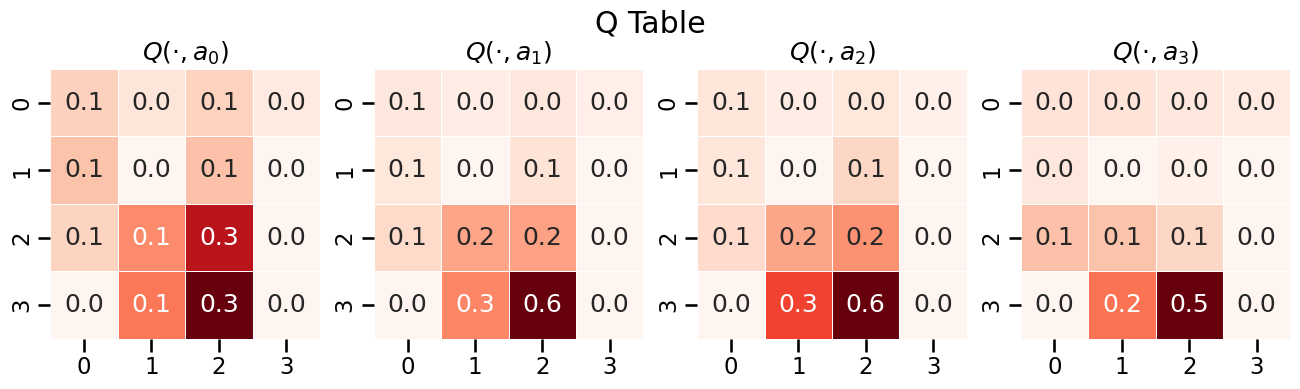

In [98]:
# Display the learned Q-table
qtable_display(q_array, title="Q Table")

### Display the evolution of the value function over iterations

In [99]:
# Make a Pandas dataframe containing the evolution of the Q-table during the learning process
q_array_history_array_ex4 = np.array(q_array_history_ex4)
df_q_hist_list_ex4 = []

for action_index in range(q_array_history_array_ex4.shape[2]):
    df_q_hist_list_ex4.append(pd.DataFrame(q_array_history_array_ex4[:, :, action_index]))

Evolution of `q_array` over iterations (one curve per state):

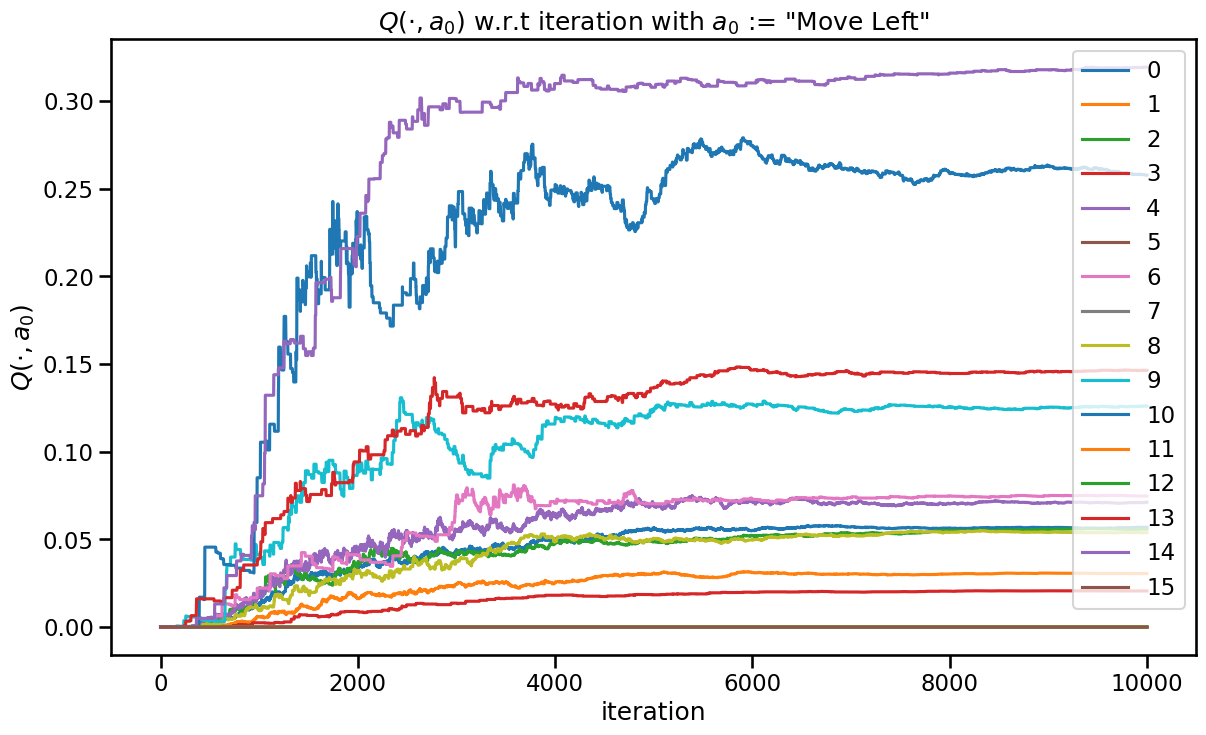

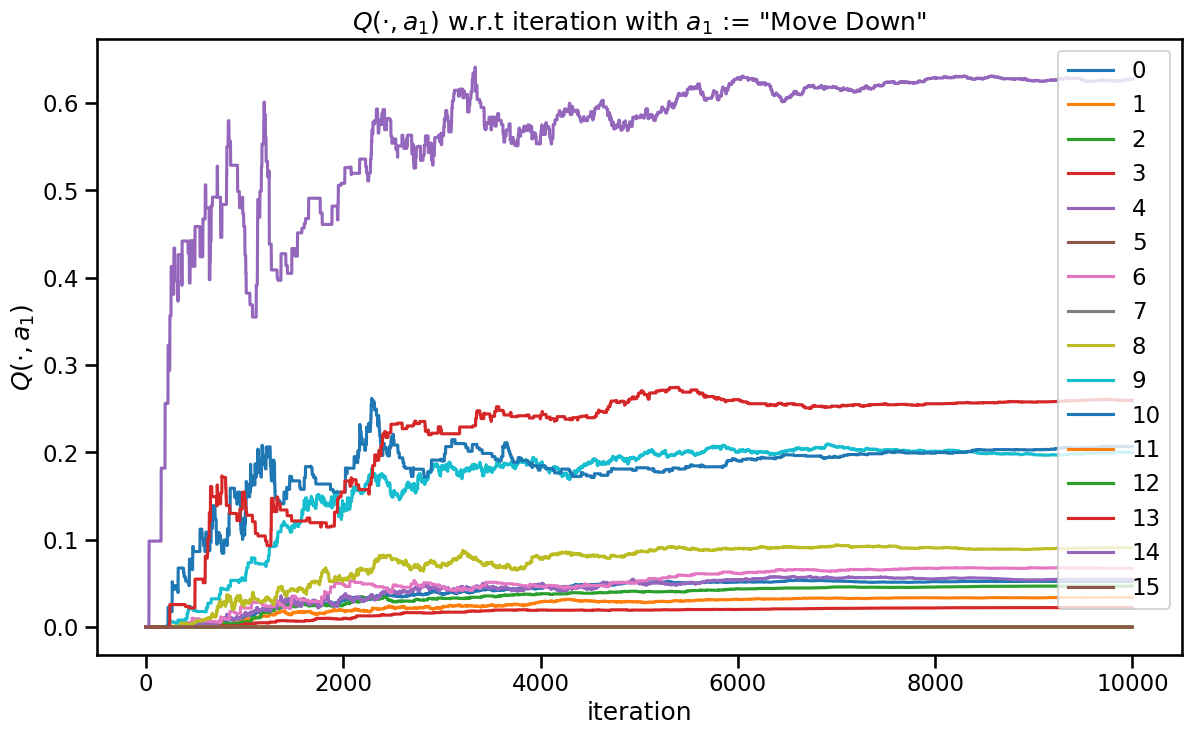

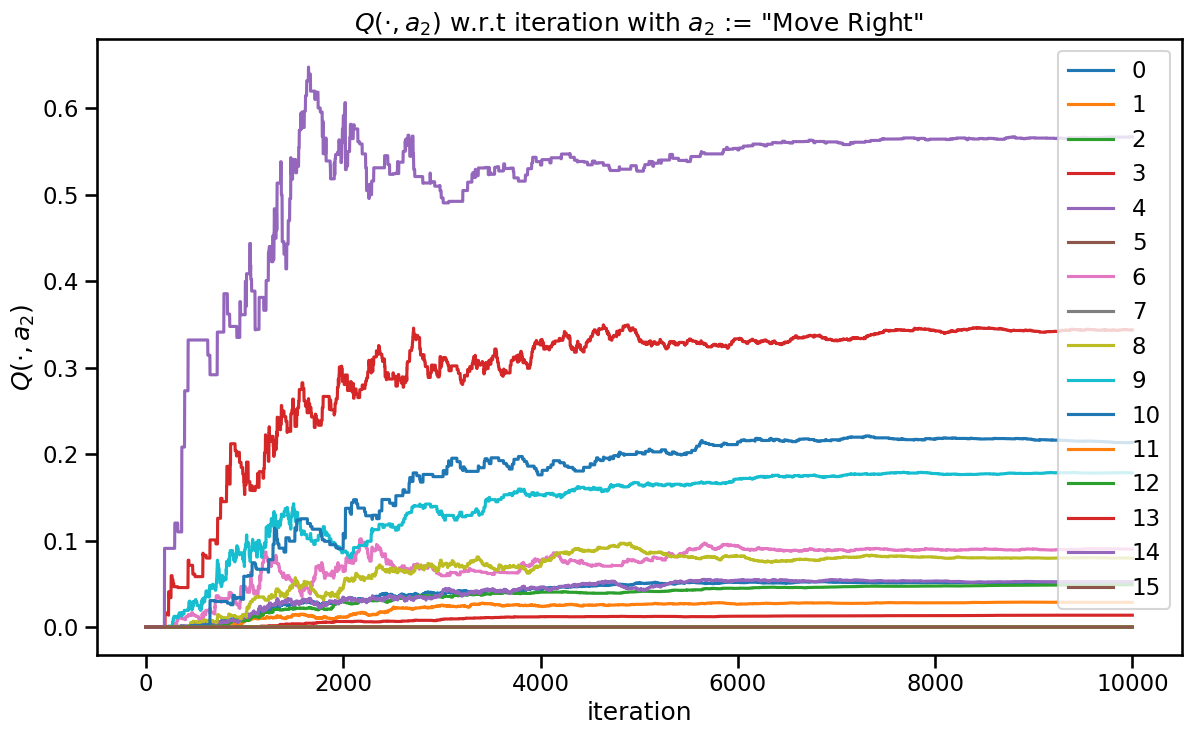

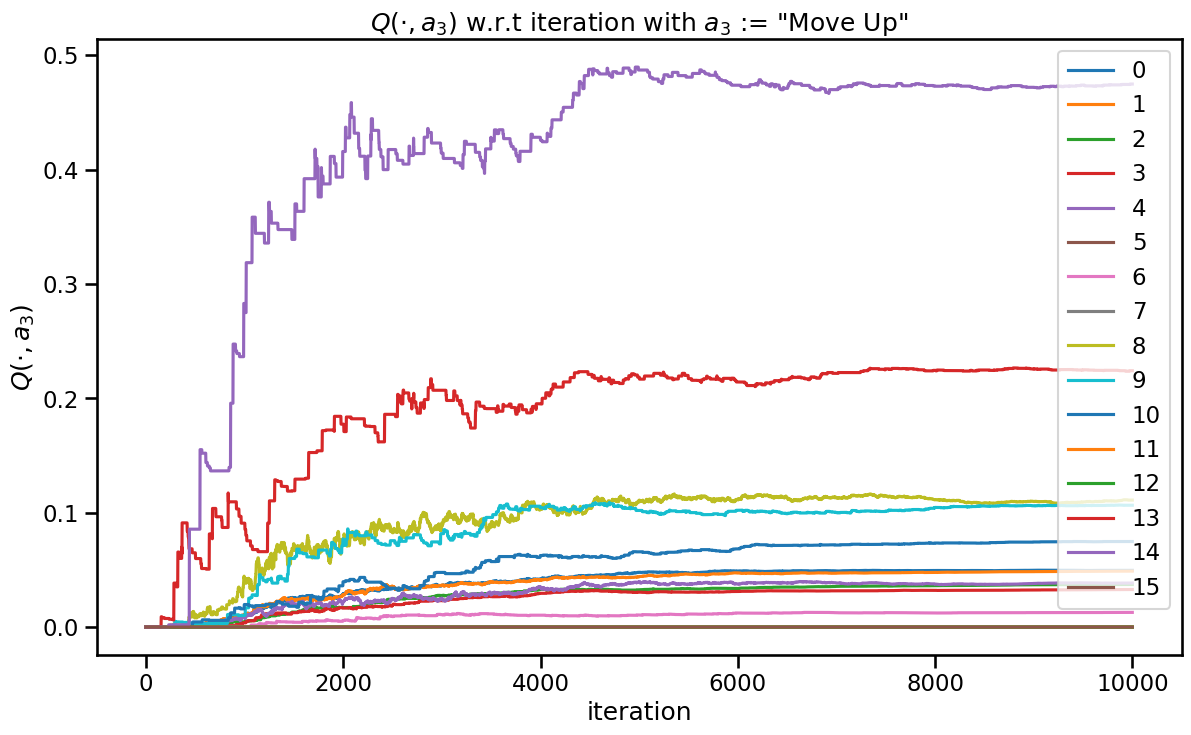

In [100]:
# Show the evolution of the estimated expected value for each action and state during the learning process
for action_index, df_q_hist in enumerate(df_q_hist_list_ex4):
    df_q_hist.plot(figsize=(14,8))
    plt.title(r'$Q(\cdot,a_{})$ w.r.t iteration with $a_{}$ := "{}"'.format(action_index, action_index, action_labels[action_index]))
    plt.ylabel(r"$Q(\cdot,a_{})$".format(action_index))
    plt.xlabel("iteration")
    plt.legend(loc='upper right');

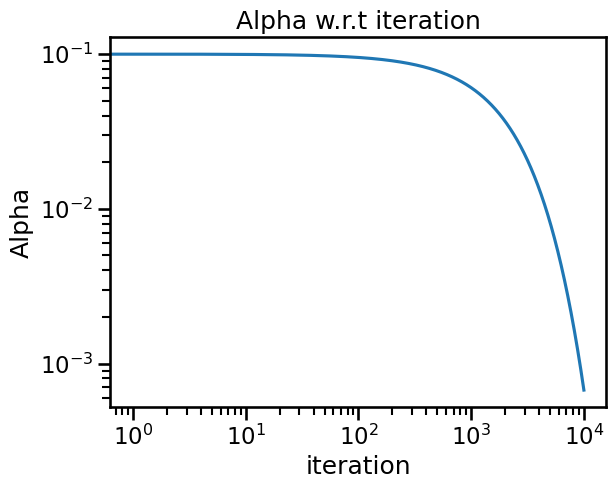

In [101]:
# Show the evolution of the alpha parameter during the learning process
plt.loglog(alpha_history_ex4)
plt.title("Alpha w.r.t iteration")
plt.ylabel("Alpha")
plt.xlabel("iteration");

### Evaluate Policy with Gymnasium

As a measure of performance, count the number of successful trials on 1000 episodes.

**Note**: Gymnasium considers the task is solved if you reach 76\% of success over the episodes.

In [102]:
environment = gym.make('FrozenLake-v1')
environment._max_episode_steps = 1000

reward_list = []
NUM_EPISODES = 1000

for episode_index in range(NUM_EPISODES):
    state, info = environment.reset()
    done = False
    #t = 0

    while not done:
        #action = epsilon_greedy_policy(state, q_array, epsilon)
        action = greedy_policy(state, q_array)
        state, reward, done, truncated, info = environment.step(action)

    reward_list.append(reward)

reward_df = pd.DataFrame(reward_list)

print('Average reward (which is equivalent to a "success rate" in the FrozenLake environment as the total rewards in this environment are either 0 or 1):', np.average(reward_df))

environment.close()

Average reward (which is equivalent to a "success rate" in the FrozenLake environment as the total rewards in this environment are either 0 or 1): 0.778


## Exercise 5: Implement the QLearning algorithm

Another reinforcement learning algorithm is the so called Q-Learning algorithm.
The fundamental difference with SARSA is that it is an off-policy algorithm.
This means that it doesn't estimate the Q-function of its current policy but it estimates the value of another policy which is the optimal one.
To do so, it uses the following update rule:
$$
Q_{t+1}(s_t, a_t) \leftarrow Q_t(s_t, a_t) + \alpha \left( r_t + \gamma \max_b Q_t(s_{t+1}, b) - Q_t(s_t, a_t) \right) .
$$

**Task**: in this exercise, you will replace the SARSA update rule by the Q-learning one and analyze the
differences in performances.

---
QLearning
---

<b>Input</b>:<br>
	$\quad\quad$ none<br>
<b>Algorithm parameter</b>:<br>
	$\quad\quad$ discount factor $\gamma$<br>
	$\quad\quad$ step size $\alpha \in (0,1]$<br>
	$\quad\quad$ small $\epsilon > 0$<br><br>

Initialize arbitrarily $Q(\boldsymbol{s}, \boldsymbol{a}) ~~~ \forall \boldsymbol{s} \in \mathcal{S}, \boldsymbol{a} \in \mathcal{A}(\boldsymbol{s})$<br>
$Q(\boldsymbol{s}_F, \cdot) = 0 ~~~ \forall \boldsymbol{s}_F \in \mathcal{S}^F$ (initialize finale states)<br><br>

<b>FOR EACH</b> episode<br>
	$\quad$ $S \leftarrow \text{env.reset}()$<br>
	$\quad$ <b>DO</b> <br>
		$\quad\quad$ $A \leftarrow \epsilon\text{-greedy}(S, Q)$<br>
		$\quad\quad$ $R, S' \leftarrow \text{env.step}(A)$<br>
		$\quad\quad$ $Q(S,A) \leftarrow Q(S,A) + \alpha \left[ \underbrace{R + \gamma ~ \max_{\boldsymbol{a}} Q(S', \boldsymbol{a}) ~ - ~ Q(S,A)}_{\text{TD error}} \right]$<br>
		$\quad\quad$ $S \leftarrow S'$<br>
	$\quad$ <b>UNTIL</b> $S$ is final

In [103]:
## EXTRACT
DISPLAY_EVERY_N_EPISODES = 50

# Initialize the history of the Q-table and learning rate
q_array_history_ex5 = []
alpha_history_ex5 = []

def q_learning(
    environment: gym.Env,
    alpha: float = 0.1,
    alpha_factor: float = 0.9995,
    gamma: float = 0.99,
    epsilon: float = 0.5,
    num_episodes: int = 10000,
    display: bool = False
) -> np.ndarray:
    """
    Perform Q-learning on a given environment.

    Parameters
    ----------
    environment : gym.Env
        The environment to learn in.
    alpha : float, optional
        The learning rate, between 0 and 1. By default 0.1
    alpha_factor : float, optional
        The factor to decrease alpha by each episode, by default 0.9995
    gamma : float, optional
        The discount factor, between 0 and 1. By default 0.99
    epsilon : float, optional
        The probability of choosing a random action, by default 0.5
    num_episodes : int, optional
        The number of episodes to run, by default 10000
    display : bool, optional
        Whether to display the Q-table (every DISPLAY_EVERY_N_EPISODES episodes), by default False

    Returns
    -------
    np.ndarray
        The learned Q-table.
        Each row corresponds to a state, and each column corresponds to an action.
        In the frozen lake environment, there are 16 states and 4 actions thus the Q-table has a shape of (16, 4).
        For instance, q_array[0, 3] is the Q-value (estimation of the expected reward) for performing action 3 ("move up") in state 0 (the top left square).
    """
    # Get the number of states and actions in the environment
    num_states = environment.observation_space.n
    num_actions = environment.action_space.n

    # Initialize the Q-table to zeros
    q_array = np.zeros([num_states, num_actions])

    # Loop over the episodes
    for episode_index in range(num_episodes):
        # Display the Q-table every DISPLAY_EVERY_N_EPISODES episodes if display is True
        if display and episode_index % DISPLAY_EVERY_N_EPISODES == 0:
            qtable_display(q_array, title="Q table")
        else:
            print('.', end="")

        # Save the current Q-table and learning rate
        q_array_history_ex5.append(q_array.copy())
        alpha_history_ex5.append(alpha)

        # Decrease the learning rate if alpha_factor is not None
        if alpha_factor is not None:
            alpha = alpha * alpha_factor

        # TODO...
        S = environment.reset()
        S = S[0]
        while True:
          A = epsilon_greedy_policy(S, q_array, epsilon)
          S_prime, R, end, _, _ = environment.step(A)
          q_array[S][A] += alpha * (R + gamma*np.max(q_array[S_prime])-q_array[S][A])
          S = S_prime
          if end:
            break

    # Return the learned Q-table
    return q_array

**Note**: In the following cell, the `display` argument can be set to `True` to see the evolution of the action-value function `q_array` over iterations.

In [104]:
# Create the environment and set the maximum number of steps per episode
environment = gym.make('FrozenLake-v1')
environment._max_episode_steps = 1000

# Initialize the history of the action-value function and learning rate
q_array_history_ex5.clear()
alpha_history_ex5.clear()

# Apply Q-learning to calculate the Q-table for the FrozenLake environment
q_array = q_learning(environment, display=False)

environment.close()

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

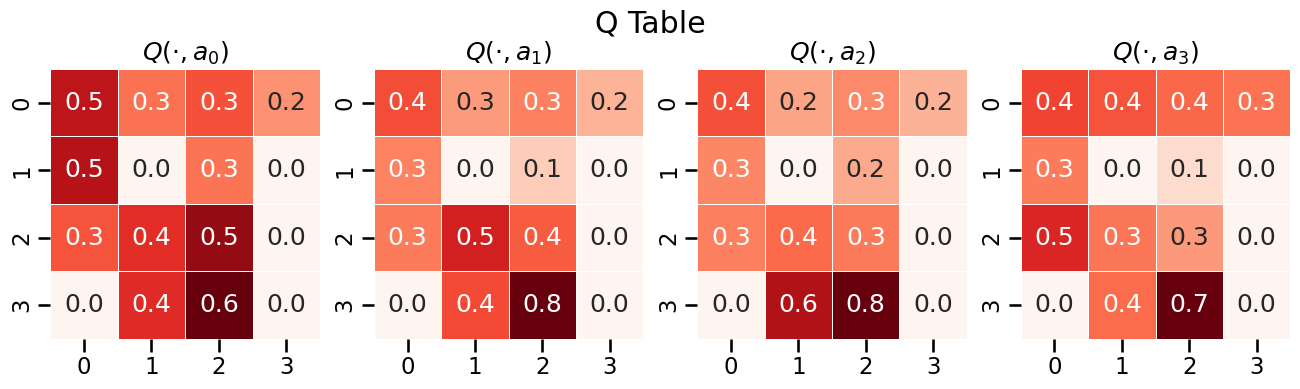

In [105]:

# Display the learned Q-table
qtable_display(q_array, title="Q Table")

### Display the evolution of the value function over iterations

In [106]:
# Make a Pandas dataframe containing the evolution of the Q-table during the learning process
q_array_history_array_ex5 = np.array(q_array_history_ex5)
df_q_hist_list_ex5 = []

for action_index in range(q_array_history_array_ex5.shape[2]):
    df_q_hist_list_ex5.append(pd.DataFrame(q_array_history_array_ex5[:, :, action_index]))

Evolution of `q_array` over iterations (one curve per state):

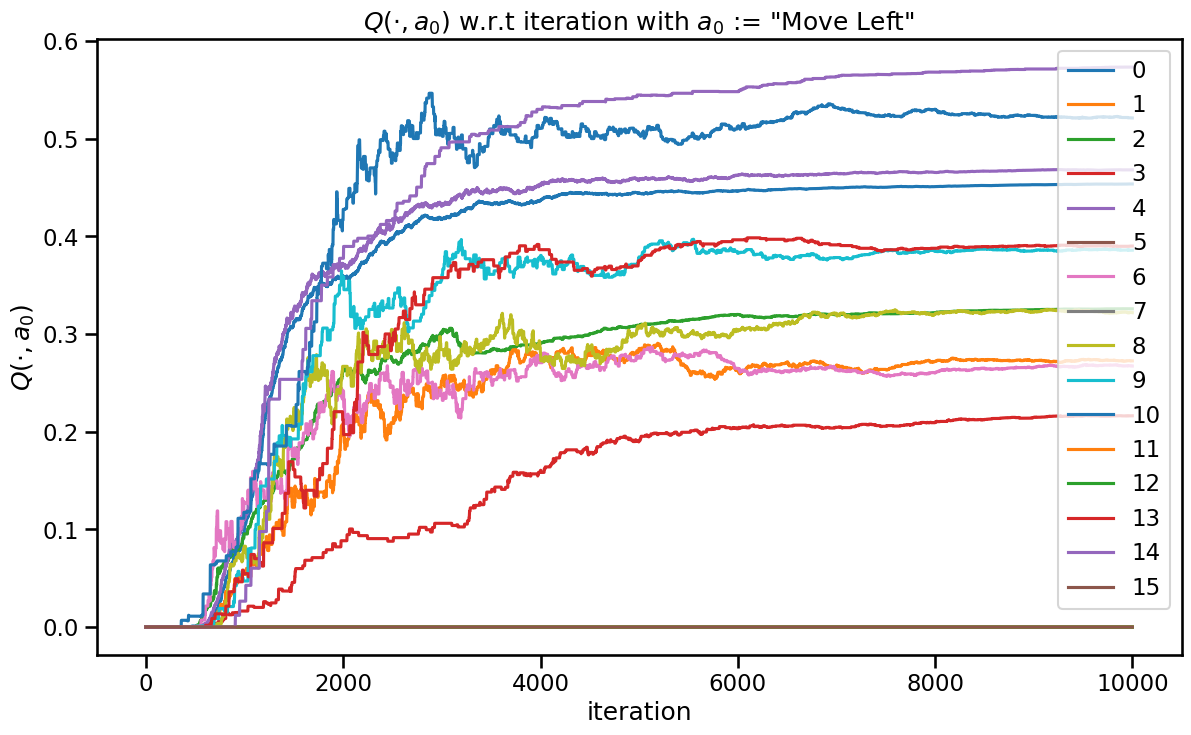

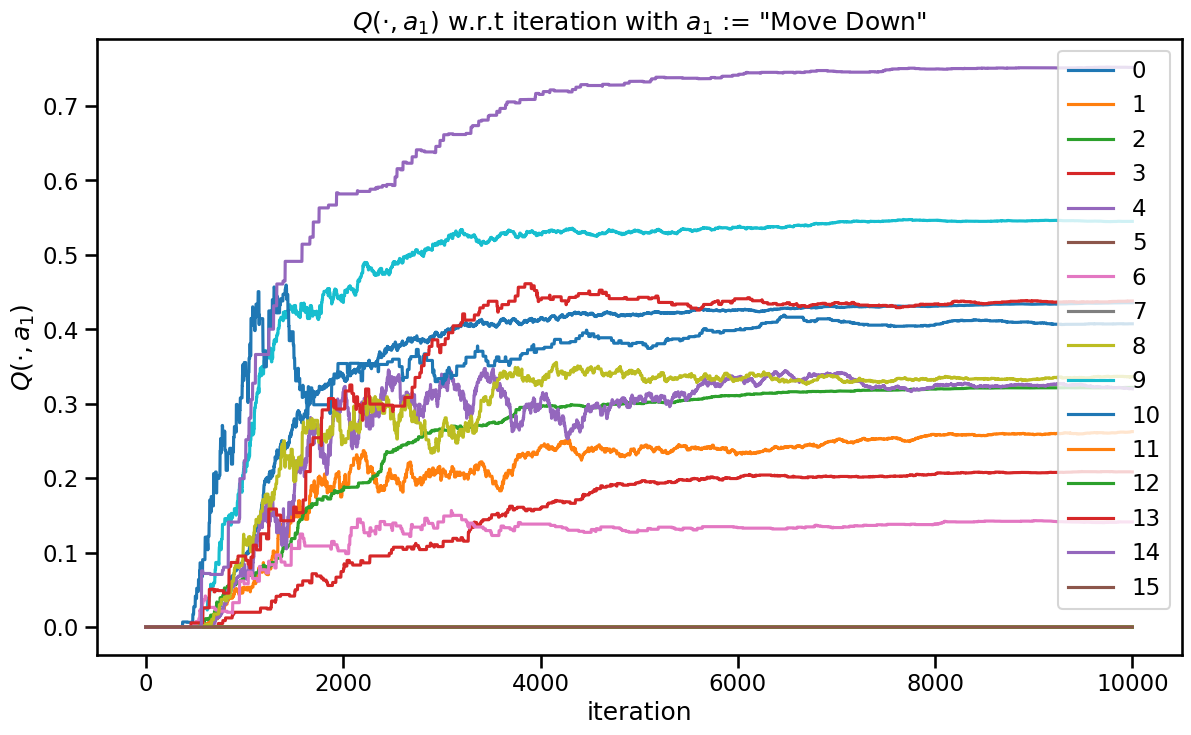

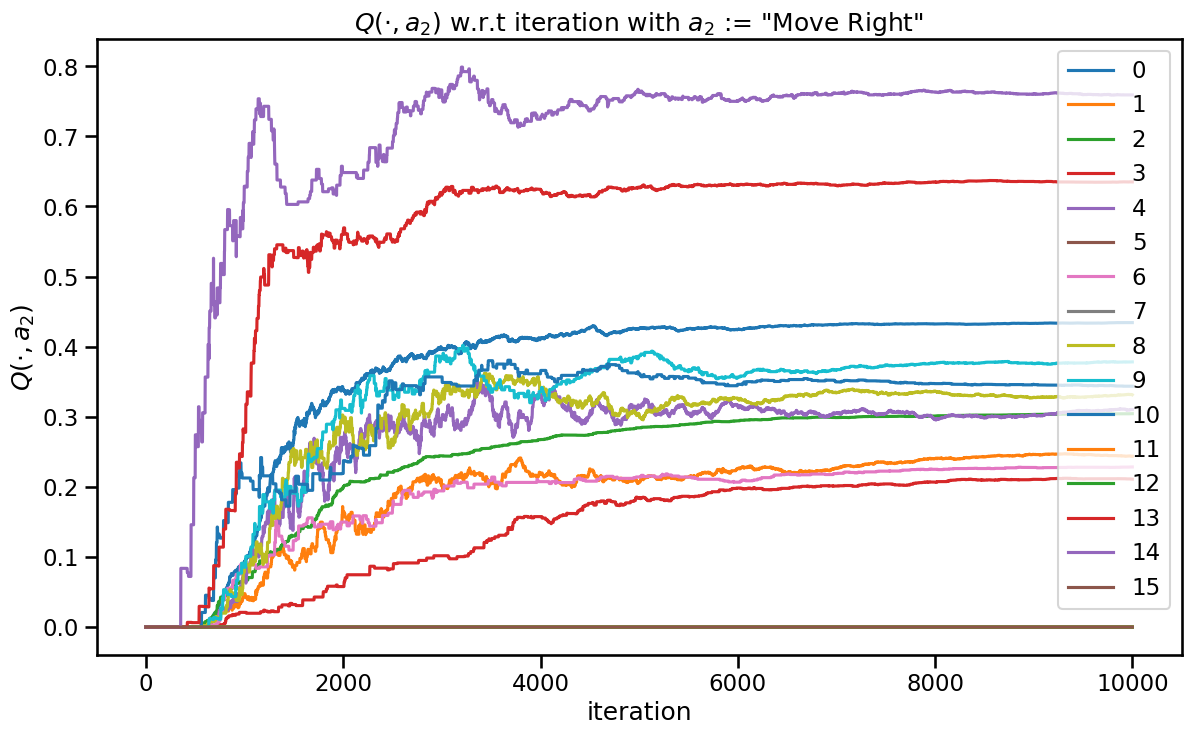

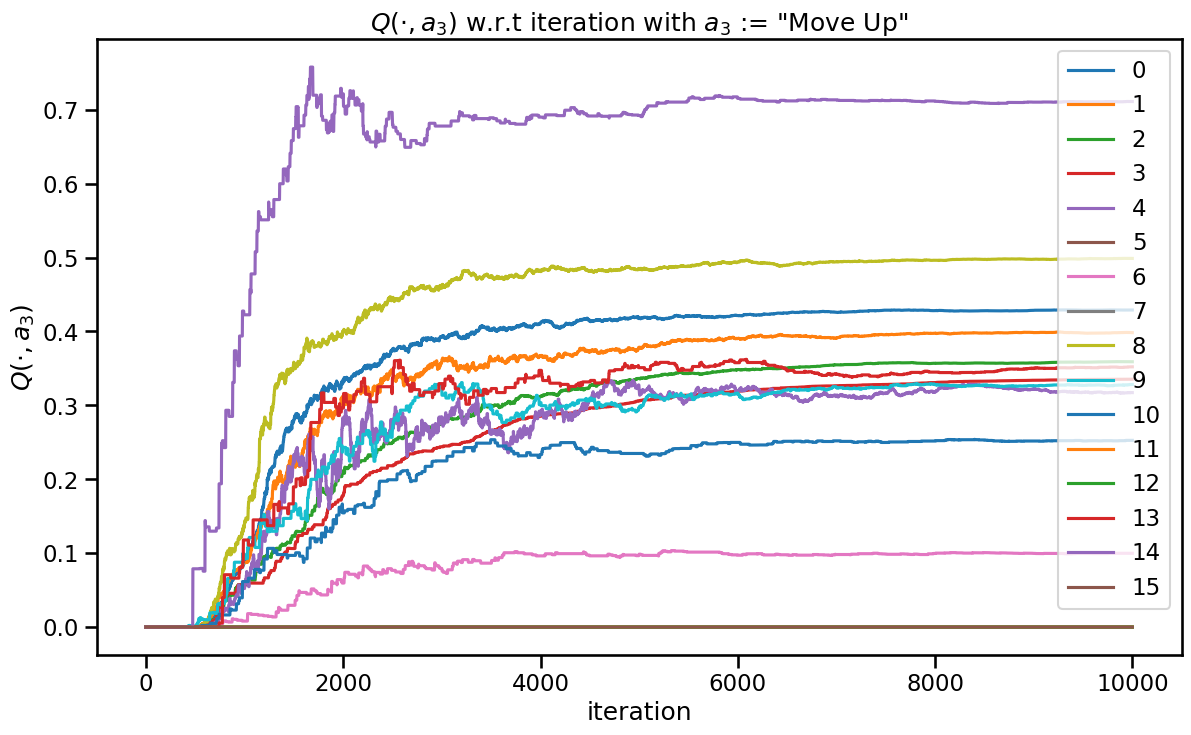

In [107]:
# Show the evolution of the estimated expected value for each action and state during the learning process
for action_index, df_q_hist in enumerate(df_q_hist_list_ex5):
    df_q_hist.plot(figsize=(14,8))
    plt.title(r'$Q(\cdot,a_{})$ w.r.t iteration with $a_{}$ := "{}"'.format(action_index, action_index, action_labels[action_index]))
    plt.ylabel(r"$Q(\cdot,a_{})$".format(action_index))
    plt.xlabel("iteration")
    plt.legend(loc='upper right');

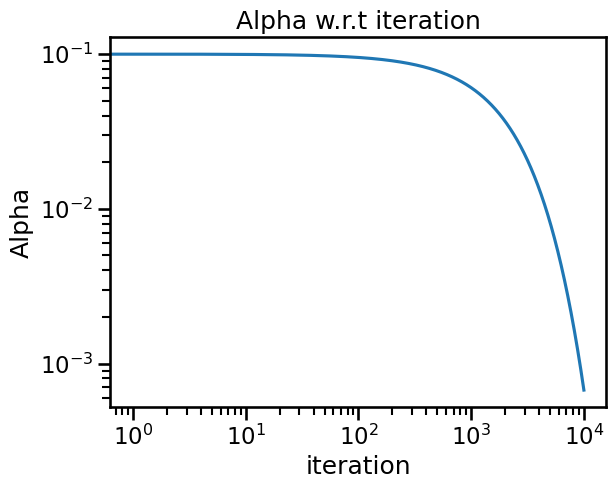

In [108]:
# Show the evolution of the alpha parameter during the learning process
plt.loglog(alpha_history_ex5)
plt.title("Alpha w.r.t iteration")
plt.ylabel("Alpha")
plt.xlabel("iteration");

### Evaluate Policy with Gymnasium

As a measure of performance, count the number of successful trials on 1000 episodes.

**Note**: Gymnasium considers the task is solved if you reach 76\% of success over the episodes.

In [112]:
environment = gym.make('FrozenLake-v1')
environment._max_episode_steps = 1000

reward_list = []
NUM_EPISODES = 1000

for episode_index in range(NUM_EPISODES):
    state, info = environment.reset()
    done = False
    #t = 0

    while not done:
        #action = epsilon_greedy_policy(state, q_array, epsilon)
        action = greedy_policy(state, q_array)
        state, reward, done, truncated, info = environment.step(action)

    reward_list.append(reward)

reward_df = pd.DataFrame(reward_list)

print('Average reward (which is equivalent to a "success rate" in the FrozenLake environment as the total rewards in this environment are either 0 or 1):', np.average(reward_df))

environment.close()

Average reward (which is equivalent to a "success rate" in the FrozenLake environment as the total rewards in this environment are either 0 or 1): 0.754
